In [1]:
import warnings
warnings.filterwarnings('ignore')

import time

import pandas as pd
import numpy as np
import scipy
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

# Helper functions

In [2]:
def change_dtypes(df):
    """
    change types of columns to reduce memory size
    :param df: dataframe
    :return df: dataframe
    """
    memory = df.memory_usage().sum() / 10**6
    print("Memory usage before changing types %0.2f MB" % memory)

    for col in df.columns:
        if (df[col].dtype == "object") and (df[col].nunique() < df.shape[0]):
            df[col] = df[col].astype("category")

        elif df[col].dtype == float:
            df[col] = df[col].astype(np.float32)

        elif df[col].dtype == int:
            df[col] = df[col].astype(np.int32)

    memory = df.memory_usage().sum() / 10 ** 6
    print("Memory usage after changing types %0.2f MB" % memory)
    return df


def load_csv(filename):
    df = pd.read_csv(filename)
    df = change_dtypes(df)
    return df

In [3]:
def check_type(val):
    if type(val) == str:
        return "string"
    
    if np.issubsctype(type(val), np.number):
        return "number"
    
    if callable(val):
        return "function"
    
    return str(type(val))


class NumColsImputer(BaseEstimator, TransformerMixin):
    def __init__(self, specified_values=None, default="median"):
        """
        :param specified_values: dict {colname (str): val (float)}, impute values for some specific columns
        :param default: str, function or float, value or function used for the remaining columns
        """
        assert (specified_values is None) or isinstance(specified_values, 
                                                        dict), "specified_values must be None or dict"
        
        self._specified_values = specified_values
        if (self._specified_values is not None) and (len(self._specified_values) > 0):
            for col, val in self._specified_values.items():
                assert check_type(val) == "number", "Impute value for " + col + " is not number."
        
        self._default = default
        self._default_type = check_type(self._default)
        if self._default_type not in ["number", "string", "function"]:
            raise ValueError("Unsupported stat type " + self._default_type)
    
    def _cal_imput_vals(self, df):
        cat_cols = df.select_dtypes(["object", "category", "bool"]).columns.to_list()
        if len(cat_cols) > 0:
            raise ValueError("There are non-number columns: " + ", ".join(cat_cols))
        
        all_cols = df.columns.to_list()
        if self._default_type == "number":
            impute_values = {col: self._default for col in all_cols}
            
        elif self._default_type == "string":
            impute_values = getattr(df, self._default)()
        
        elif self._default_type == "function":
            impute_values = df.apply(self._default)
        
        else:
            raise ValueError("Unknown default imputer:", self._default)
        
        # if it is a pandas series, turn it into dict
        impute_values = dict(impute_values)
        if (self._specified_values is None) or (len(self._specified_values) == 0):
            return impute_values
        
        for col in self._specified_values:
            impute_values[col] = self._specified_values[col]
            
        return impute_values
    
    def fit(self, df):
        impute_values = self._cal_imput_vals(df)
        
        cols_with_na = [col for col in df.columns if df[col].isnull().any()]
        self._impute_values = {col: impute_values[col] for col in cols_with_na}
        
        for k, v in self._impute_values.items():
            if np.isnan(v):
                raise ValueError("One of the impute_values is NaN: " + k)
        
        return self
    
    def transform(self, df):
        return df.fillna(self._impute_values)


class CatColsImputer(BaseEstimator, TransformerMixin):
    def __init__(self, specified_values=None, default="missing_value"):
        """
        :param specified_values: dict {colname (str): val (str, float, function)}, 
                                 impute values for some specific columns
        :param default: str, used for the remaining columns
        """
        assert (specified_values is None) or isinstance(specified_values, 
                                                        dict), "specified_values must be None or dict"
        
        self._specified_values = specified_values
        if (self._specified_values is not None) and (len(self._specified_values) > 0):
            for col, val in self._specified_values.items():
                assert check_type(val) in ["string", 
                                           "function"], "Impute value for " + col + " is " + check_type(val)
        
        self._default = default
        assert check_type(self._default) == "string", "default must be string"
        
        
    def _cal_imput_vals(self, df):
        num_cols = df.select_dtypes(["number"]).columns.to_list()
        if len(num_cols) > 0:
            raise ValueError("There are number columns: " + ", ".join(num_cols))
        
        all_cols = df.columns.to_list()
        impute_values = {col: self._default for col in all_cols}
        if (self._specified_values is None) or (len(self._specified_values) == 0):
            return impute_values
        
        for col, val in self._specified_values.items():
            dtype = check_type(val)
            if dtype == "string":
                impute_values[col] = val
            
            elif dtype == "function":
                impute_values[col] = val(df[col])
            
            else:
                raise ValueError("Unknown imputer for " + col + ": ", str(val))
        return impute_values
    
    def fit(self, df):
        impute_values = self._cal_imput_vals(df)
        
        cols_with_na = [col for col in df.columns if df[col].isnull().any()]
        self._impute_values = {col: impute_values[col] for col in cols_with_na}
        
        return self
    
    def transform(self, df):
        df_new = df.copy()
        for col, val in self._impute_values.items():
            df_new[col] = df_new[col].astype("object").fillna(val).astype("category")
            
        return df_new


def get_colnames_from_regex(df, regex_strings):
    cols = []
    for regex_str in regex_strings:
        cols.extend(df.filter(regex=regex_str).columns.to_list())
    return cols


class Imputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        raise NotImplementedError("Not implemented")
        
        self._regex_strings = None
        self._spec_impt_regex_val_num = None
        
        self._spec_impt_vals_num = {}
        self._default_imput_vals_num = "median"
        
        self._spec_impt_vals_cat = {}
        self._default_imput_vals_cat = "missing_value"
    
    def fit(self, df_train):
        df_num = df_train.select_dtypes(["number"])
        cols_num = df_num.columns.to_list()
                
        if self._regex_strings is not None:
            cols_imput_with_regex = get_colnames_from_regex(df_train, self._regex_strings)
            # make sure they are in cols_num
            cols_imput_with_regex = [col for col in cols_imput_with_regex if col in cols_num]
            
            self._spec_impt_vals_num.update({col: self._spec_impt_regex_val_num 
                                             for col in cols_imput_with_regex})
        
        self._imputer_num = NumColsImputer(specified_values=self._spec_impt_vals_num, 
                                           default=self._default_imput_vals_num)
        self._imputer_num.fit(df_num)
        
        df_cat = df_train.select_dtypes(["object", "category", "bool"])
        self._imputer_cat = CatColsImputer(specified_values=self._spec_impt_vals_cat, 
                                           default=self._default_imput_vals_cat)
        self._imputer_cat.fit(df_cat)
        
        return self
    
    def transform(self, df):
        dfs = []
        num_df = df.select_dtypes(["number"])
        
        if len(self._spec_impt_vals_num) > 0:
            some_col = list(self._spec_impt_vals_num.keys())[0]
            isnull_df = num_df[[some_col]]
            for col in self._spec_impt_vals_num:
                isnull_df[col + "_ISNULL"] = num_df[col].isnull()
                
            isnull_df = isnull_df.drop([some_col], axis="columns")
            dfs.append(isnull_df)
        
        num_df = self._imputer_num.transform(num_df)
        dfs.append(num_df)
        
        # cat
        cat_df = df.select_dtypes(["object", "category", "bool"])
        cat_df = self._imputer_cat.transform(cat_df)
        dfs.append(cat_df)
        
        return pd.concat(dfs, axis="columns")
    

class DefaultImputer(Imputer):
    def __init__(self):
        self._regex_strings = None
        self._spec_impt_regex_val_num = None
        
        self._spec_impt_vals_num = {}
        self._default_imput_vals_num = 0.
        
        self._spec_impt_vals_cat = {}
        self._default_imput_vals_cat = "missing_value"

In [4]:
class CollinearColumnRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold, col_regex=None):
        """
        :param threshold: float in [0, 1], if two columns have correlation greater than threshold
                          one of them will be removed
        :param col_regex: str, regular expression to select columns
        """
        self._threshold = threshold
        self._col_regex = col_regex
    
    def _collinear_columns(self, df, threshold):
        if self._col_regex is None:
            df_sel = df.select_dtypes(["number", "bool"])
        else:
            df_sel = df.filter(regex=self._col_regex)
            df_sel = df_sel.select_dtypes(["number", "bool"])
        
        df_sel = df_sel.astype("float32")
        
        all_cols = df_sel.columns.to_list()
        ncols = len(all_cols)
        
        corr_mat = df_sel.corr().abs()
        self._corr_mat = corr_mat
        collin_cols = []
        for i in range(ncols-1):
            col_i = all_cols[i]
            if col_i in collin_cols:
                continue
            
            for j in range(i + 1, ncols):
                col_j = all_cols[j]
                if col_j in collin_cols:
                    continue
                
                corr = corr_mat.loc[col_i, col_j]
                if corr > threshold:
                    collin_cols.append(col_j)
        
        collin_cols = list(set(collin_cols))
        return collin_cols
    
    
    def fit(self, df):
        self._collin_cols = self._collinear_columns(df, self._threshold)
        return self
    
    def transform(self, df):
        all_cols = df.columns.to_list()
        nonexist_cols = [col for col in self._collin_cols if col not in all_cols]
        if len(nonexist_cols) > 0:
            print("WARNING: These collinear cols to be droped do not exist in df:", nonexist_cols)
            
        droped_col = [col for col in self._collin_cols if col in all_cols]
        print("Number of columns droped due to collinearity:", len(droped_col))
        return df.drop(droped_col, axis="columns")


class ConstantColumnsRemover(BaseEstimator, TransformerMixin):
    def fit(self, df_train):
        all_cols = df_train.columns
        self._cols_to_remove = []
        
        for col in all_cols:
            if df_train[col].nunique() == 1:
                self._cols_to_remove.append(col)
        return self
    
    def transform(self, df):
        print("Number of constant columns droped:", len(self._cols_to_remove))
        return df.drop(self._cols_to_remove, axis="columns")
                
        
class SameCatColsRemover(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=0.99):
        self._threshold = threshold
    
    def fit(self, df_train):
        cols = df_train.select_dtypes(["category", "object"]).columns.to_list()
        ncols = len(cols)
        
        self._cols_to_drop = []
        for i in range(ncols - 1):
            col_i = cols[i]
            if col_i in self._cols_to_drop:
                continue
            
            for j in range(i + 1, ncols):
                col_j = cols[j]
                if col_j in self._cols_to_drop:
                    continue
                
                if (df_train[col_i].astype("object") == df_train[col_j].astype("object")).mean() > self._threshold:
                    self._cols_to_drop.append(col_j)
        
        return self
    
    def transform(self, df):
        print("Number of same columns droped:", len(self._cols_to_drop))
        return df.drop(self._cols_to_drop, axis="columns")


class OneHotEncoder(BaseEstimator, TransformerMixin):
    def fit(self, train_df):
        df_cat = train_df.select_dtypes(["object", "category"])
        self._cat_cols = df_cat.columns.to_list()
        
        if len(self._cat_cols) > 0:
            self._cat_cols_ohe = pd.get_dummies(df_cat, drop_first=True).columns.to_list()
        else:
            self._cat_cols_ohe = []
        return self
    
    def transform(self, df):
        if len(self._cat_cols) == 0:
            print("No cat cols in df_train, so do nothing.")
            return df
        
        df_cat = df.select_dtypes(["object", "category"])
        cat_cols = df_cat.columns.to_list()
        assert set(cat_cols) == set(self._cat_cols), "df does not have the same categorical cols as train_df"
        
        # one-hot encode
        df_cat = pd.get_dummies(df_cat)
        # drop cols that are present in test_df but absent in train_df
        cols_to_drop = [col for col in df_cat.columns if col not in self._cat_cols_ohe]
        df_cat = df_cat.drop(cols_to_drop, axis="columns")
        
        # change to float32
        for col in df_cat.columns:
            df_cat[col] = df_cat[col].astype("float32")
        
        # if some some colums are absent in test but present in train, make them all zero 
        cat_cols_ohe = df_cat.columns.to_list()
        for col in self._cat_cols_ohe:
            if col not in cat_cols_ohe:
                df_cat[col] = 0
                df_cat[col] = df_cat[col].astype(np.uint8)
        
        num_cols = [col for col in df.columns if col not in cat_cols]
        df_num = df[num_cols]
        
        return pd.concat([df_num, df_cat], axis="columns")


class Standardizer(BaseEstimator, TransformerMixin):
    def __init__(self, to_array=False):
        self._to_array = to_array
        
    def fit(self, df_train):
        num_cols = df_train.select_dtypes(["number"]).columns.to_list()
        self._mean = {col: df_train[col].mean() for col in num_cols}
        self._std = {col: df_train[col].std() for col in num_cols}
        return self
    
    def transform(self, df):
        for col in self._mean:
            if self._std[col] > 0:
                df[col] = (df[col] - self._mean[col]) / self._std[col]
                df[col] = df[col].astype("float32")
            else:
                print("WARNING: " + col + " has zero std.")
        if self._to_array:
            return df.values.astype(np.float32)
        else:
            return df

In [5]:
class NumColsQCuter(BaseEstimator, TransformerMixin):
    
    def __init__(self, labels=None, exclude_cols=None, 
                 nunique_min=1000, keep_old=True, 
                 output_type=np.int32):
        
        if labels is None:
            self._labels = list(range(1, 11))
        else:
            self._labels = list(labels)
        self._nbins = len(self._labels)
        assert self._isunique(self._labels), "labels must be unique"
        
        self._exclude_cols = ["SK_ID_CURR", "TARGET", "SK_ID_BUREAU", "SK_ID_PREV"]
        if exclude_cols is not None:
            self._exclude_cols = self._exclude_cols + list(exclude_cols)
        
        self._nunique_min = nunique_min
        
        self._suffix = "_%dQCUT" % len(self._labels)
        
        self._keep_old = keep_old
        self._output_type = output_type
    
    def _isunique(self, x):
        return len(np.unique(x)) == len(x)
    
    def fit(self, df_train):
        
        quantiles = np.linspace(0, 1, self._nbins + 1)
        quantiles = quantiles[1: -1]
        
        sel_cols = df_train.select_dtypes(["number"]).columns.to_list()
        sel_cols = [col for col in sel_cols if col not in self._exclude_cols]
        sel_cols = [col for col in sel_cols if df_train[col].nunique() >= self._nunique_min]
        
        self._bins = {}
        for col in sel_cols:
            #if df_train[col].isnull().any():
            #    raise ValueError(col + " has null values")
            
            bins = df_train[col].quantile(quantiles).values
            bins = np.array([-np.inf] + list(bins) + [np.inf])
            
            if self._isunique(bins):
                self._bins[col] = bins
        
        return self
    
    def transform(self, df):
        df = df.copy()
        new_cols = []
        for col, bins in self._bins.items():
            new_col_name = col + self._suffix
            df[new_col_name] = pd.cut(df[col], bins, labels=self._labels)
            df[new_col_name] = df[new_col_name].astype(self._output_type)
            
            new_cols.append(new_col_name)
            
        if self._keep_old:
            return df
        else:
            return df[new_cols]

In [6]:
def flatten_multiindex_cols(columns):
    fat_cols = ["_".join([str(c) for c in flat_col]) for flat_col in columns.to_flat_index()]
    return fat_cols


def agg_num_cols(df, by_sers, stats):
    assert type(by_sers) in [list, tuple], "by_sers must be a list or tuple"
    assert type(stats) in [list, tuple], "stats must be a list or tuple"
    
    for ser in by_sers:
        assert isinstance(ser, pd.Series), "ser in by_sers must be Series"
        
    cat_cols = df.select_dtypes(["object", "category"]).columns.to_list()
    if len(cat_cols) > 0:
        raise ValueError("There are non-number cols: " + ", ".join(cat_cols))
    
    df_agg = df.groupby(by_sers).agg(stats)
    df_agg.columns = flatten_multiindex_cols(df_agg.columns)
    
    return df_agg


def agg_cat_cols(df, by_sers, stats):
    assert type(by_sers) in [list, tuple], "by_sers must be a list or tuple"
    assert type(stats) in [list, tuple], "stats must be a list or tuple"
    
    for ser in by_sers:
        assert isinstance(ser, pd.Series), "ser in by_sers must be Series"
        
    num_cols = df.select_dtypes(["number"]).columns.to_list()
    if len(num_cols) > 0:
        raise ValueError("There are number cols: " + ", ".join(num_cols))
    
    df_agg = df.groupby(by_sers).agg(stats)
    df_agg.columns = flatten_multiindex_cols(df_agg.columns)
    
    return df_agg


class Aggregator(BaseEstimator, TransformerMixin):
    
    def __init__(self, by_list_cols, 
                 num_stats, bool_stats, cat_stats, 
                 ohe_cat_stats=None,
                 ohe_cat_max_class=None,
                 iqr=False, minmax_range=False, mean_median_diff=False):
        """
        :param by_list_cols: list of str, cols by which the dataframe is grouped
        :param num_stats: list, aggregating functions for numerical columns
        :param bool_stats: list, aggregating functions for bool columns
        :param cat_stats: list, aggregating functions for category columns
        :param ohe_cat_stats: list, aggregating functions for category columns after one-hot encoded
        :param ohe_cat_max_class: int, category columns with at most ohe_cat_max_class classes 
                                 will be one-hot encoded before aggregating, 
                                 If None, no one-hot encoding will be done.
        """
        
        self._by_list_cols = by_list_cols
        
        self._num_stats = num_stats
        self._bool_stats = bool_stats
        self._cat_stats = cat_stats
        self._ohe_cat_stats = ohe_cat_stats
        
        if ohe_cat_max_class is None:
            self._ohe_cat_max_class = ["mean", "sum"]
        else:
            self._ohe_cat_max_class = ohe_cat_max_class
        
        self._iqr = iqr
        self._minmax_range = minmax_range
        self._mean_median_diff = mean_median_diff
    
    def _num_agg(self, df, by_sers):
        agg_df = agg_num_cols(df, by_sers, stats=self._num_stats)
        return agg_df
    
    def _bool_agg(self, df, by_sers):
        agg_df = agg_num_cols(df, by_sers, stats=self._bool_stats)
        return agg_df
    
    def _cat_agg(self, df, by_sers):
        agg_df =  agg_cat_cols(df, by_sers, stats=self._cat_stats)
        return agg_df
    
    def _ohe_cat_agg(self, df, by_sers):
        agg_df = agg_num_cols(df, by_sers, stats=self._ohe_cat_stats)
        return agg_df
    
    
    def _iqr_agg(self, num_df, by_sers):
        grouped = num_df.groupby(by_sers)
        iqr_df = grouped.quantile(0.75) - grouped.quantile(0.25)
        iqr_df.columns = [col + "_iqr" for col in iqr_df.columns]
        return iqr_df
    
    def _range_agg(self, num_df, by_sers):
        grouped = num_df.groupby(by_sers)
        range_df = grouped.max() - grouped.min()
        range_df.columns = [col + "_range" for col in range_df.columns]
        return range_df
    
    def _mm_diff_agg(self, num_df, by_sers):
        grouped = num_df.groupby(by_sers)
        diff_df = grouped.mean() - grouped.median()
        diff_df.columns = [col + "_mm_diff" for col in diff_df.columns]
        return diff_df
    
    def _cat_cols_to_ohe(self, df_train):
        cat_cols = []
        if self._ohe_cat_max_class is None:
            return cat_cols
        
        for col in self._cat_cols:
            if df_train[col].nunique() <=  self._ohe_cat_max_class:
                for cl in df_train[col].unique():
                    cat_cols.append(col + "_" + str(cl))
        return cat_cols
        
    def fit(self, df_train):
        df_train = df_train.drop(self._by_list_cols, axis="columns")
        
        self._ohe = OneHotEncoder()
        self._ohe.fit(df_train)
        
        self._bool_cols = df_train.select_dtypes(["bool"]).columns.to_list()
        self._cat_cols = df_train.select_dtypes(["category", "object"]).columns.to_list()
        self._num_cols = df_train.select_dtypes(["number"]).columns.to_list()
        
        # cat column names after being one-hot encoded
        all_cat_ohe_cols = self._ohe.transform(df_train).columns.to_list()
        self._cat_cols_ohe = []
        if self._ohe_cat_max_class is not None:
            for col in self._cat_cols:
                if df_train[col].nunique() <=  self._ohe_cat_max_class:
                    for cl in df_train[col].unique():
                        ohe_col = col + "_" + str(cl)
                        
                        if ohe_col in all_cat_ohe_cols:
                            self._cat_cols_ohe.append(ohe_col)
                        
        return self
    
    def transform(self, df):
        by_sers = [df[col] for col in self._by_list_cols]
        df = df.drop(self._by_list_cols, axis="columns")
        
        all_cols = df.columns.to_list()
        for col in self._bool_cols + self._cat_cols + self._num_cols:
            if col not in all_cols:
                raise ValueError(col + " exists in train but not in test")
        
        dfs = []
        
        # bool cols
        if len(self._bool_cols) > 0:
            df_bool = df[self._bool_cols]
            print("Aggregating bool df with shape:", df_bool.shape)
            df_bool = self._bool_agg(df_bool, by_sers)
            
            for col in df_bool.columns:
                if col.endswith("_mean") or col.endswith("_sum") or col.endswith("_entropy"):
                    df_bool[col] = df_bool[col].astype("float32")
                
                if col.endswith("_mode"):
                    df_bool[col] = df_bool[col].astype("category")
            dfs.append(df_bool)
        
        # categorical cols
        if len(self._cat_cols) > 0:
            df_cat = df[self._cat_cols]
            print("Aggregating cat df with shape:", df_cat.shape)
            df_cat = self._cat_agg(df_cat, by_sers)
            
            for col in df_cat.columns:
                if col.endswith("_mean") or col.endswith("_entropy"):
                    df_cat[col] = df_cat[col].astype("float32")
                
                if col.endswith("_mode"):
                    df_cat[col] = df_cat[col].astype("category")
            
            dfs.append(df_cat)
        
        # number cols
        df_num = df[self._num_cols]
        if df_num.shape[1] > 0:
            print("Aggregating num df with shape:", df_num.shape)
            df_num = self._num_agg(df_num, by_sers)
            dfs.append(df_num)
        
        # ohe cat cols
        if len(self._cat_cols_ohe) > 0:
            df_ohe = self._ohe.transform(df)
            for col in self._cat_cols_ohe:
                if col not in df_ohe.columns:
                    raise ValueError(col + " is not in cols of df_ohe")
                    
            df_ohe = df_ohe[self._cat_cols_ohe]
            print("Aggregating ohe cat df with shape:", df_ohe.shape)
            
            df_ohe = self._ohe_cat_agg(df_ohe, by_sers)
            dfs.append(df_ohe)
        
        # aggregate num cols with iqr, range and mean-median difference
        df_num = df.select_dtypes(["number"])
        print("df_num.shape for iqr, mimmax_range, mean_median_diff", df_num.shape)
            
        if self._iqr and df_num.shape[1] > 0:
            print("Aggregating num df with iqr")
            df_iqr = self._iqr_agg(df_num, by_sers)
            dfs.append(df_iqr)
        
        if self._minmax_range and df_num.shape[1] > 0:
            print("Aggregating num df with range")
            df_range = self._range_agg(df_num, by_sers)
            print("df_range.shape", df_range.shape)
            dfs.append(df_range)
        
        if self._mean_median_diff and df_num.shape[1] > 0:
            print("Aggregating num df with mean-median difference")
            df_diff = self._mm_diff_agg(df_num, by_sers)
            dfs.append(df_diff)
        
        return pd.concat(dfs, axis="columns")

In [7]:
def train_test_partition(df, matching_key, train_id_ser):
    is_train = df[matching_key].isin(train_id_ser.values)
    
    train = df.loc[is_train, :]
    test = df.loc[~is_train, :]
    return train, test

In [8]:
def mode(ser):
    return ser.mode().values[0]


def entropy(ser):
    pk = ser.value_counts(normalize=True)
    return stats.entropy(pk)


def hh_index(ser):
    pk = ser.value_counts(normalize=True)
    return (pk * pk).sum()

# Feature extraction from `application_[train|test]`

In [9]:
class ApplImputer(Imputer):
    def __init__(self):
        self._regex_strings = ["^APARTMENTS_", "^BASEMENTAREA_", "^YEARS_B", "^COMMONAREA_", 
                               "^ELEVATORS_", "^ENTRANCES_", "^FLOORS", "^LANDAREA_", "^LIVING", 
                               "^NONLIVING", "AMT_REQ_CREDIT_BUREAU_"]
        self._spec_impt_regex_val_num = -1.
        
        self._spec_impt_vals_num = {"OWN_CAR_AGE": -1.,
                                    "EXT_SOURCE_1": 0.,
                                    "EXT_SOURCE_3": 0.,
                                    "TOTALAREA_MODE": -1.}
        self._default_imput_vals_num = "median"
        
        self._spec_impt_vals_cat = None
        self._default_imput_vals_cat = "missing_value"
        

class ApplNewColsAdder(BaseEstimator, TransformerMixin):
    def fit(self, df_train):
        credit_to_income = df_train["AMT_CREDIT"] / df_train["AMT_INCOME_TOTAL"]
        self._cti_min = credit_to_income.replace(-np.inf, np.nan).min() / 10.
        self._cti_max = credit_to_income.replace(np.inf, np.nan).max() * 10.
        
        credit_to_goods = df_train["AMT_CREDIT"] / df_train["AMT_GOODS_PRICE"]
        self._ctg_min = credit_to_goods.replace(-np.inf, np.nan).min() / 10.
        self._ctg_max = credit_to_goods.replace(np.inf, np.nan).max() * 10.
    
    def transform(self, df):
        df_new = df.copy()
        df_new["AMT_INCOME_TOTAL_LOG"] = np.log(df_new["AMT_INCOME_TOTAL"])
        df_new["DAYS_EMPLOYED_POSITIVE"] = df_new["DAYS_EMPLOYED"] > 0
        days_emp_max = df_new["DAYS_EMPLOYED"].max()
        if days_emp_max > 0:
            df_new["DAYS_EMPLOYED"] = df_new["DAYS_EMPLOYED"].replace({days_emp_max: 100.})
        
        df_new["CREDIT_TO_INCOME"] = df_new["AMT_CREDIT"] / df_new["AMT_INCOME_TOTAL"]
        df_new["CREDIT_TO_INCOME"] = df_new["CREDIT_TO_INCOME"].replace(-np.inf, self._cti_min)
        df_new["CREDIT_TO_INCOME"] = df_new["CREDIT_TO_INCOME"].replace(np.inf, self._cti_max)
        
        df_new["CREDIT_TO_GOODS"] = df_new["AMT_CREDIT"] / df_new["AMT_GOODS_PRICE"]
        df_new["CREDIT_TO_GOODS"] = df_new["CREDIT_TO_GOODS"].replace(-np.inf, self._ctg_min)
        df_new["CREDIT_TO_GOODS"] = df_new["CREDIT_TO_GOODS"].replace(np.inf, self._ctg_max)
        
        return df_new

In [ ]:
application_train = load_csv("data/download/application_train.csv")
application_test = load_csv("data/download/application_test.csv")

appl_train_key = application_train["SK_ID_CURR"]
appl_test_key = application_test["SK_ID_CURR"]
print(application_train.shape, application_test.shape)

In [ ]:
time_start = time.time()

appl_train = application_train.copy()
appl_test = application_test.copy()
print("appl_train.shape", appl_train.shape)
print("appl_test.shape", appl_test.shape)


print("Bin numerical columns")
numcolsqcuter = NumColsQCuter()
numcolsqcuter.fit(appl_train)
appl_train = numcolsqcuter.transform(appl_train)
appl_test = numcolsqcuter.transform(appl_test)
print("appl_train.shape", appl_train.shape)
print("appl_test.shape", appl_test.shape)


print("Impute missing values")
imputer = ApplImputer()
imputer.fit(appl_train)
appl_train = imputer.transform(appl_train)
appl_test = imputer.transform(appl_test)
print("appl_train.isnull().sum().sum()", appl_train.isnull().sum().sum())
print("appl_test.isnull().sum().sum()", appl_test.isnull().sum().sum())


print("Remove collinear columns")
remover = CollinearColumnRemover(0.95, col_regex="_ISNULL$")
remover.fit(appl_train)
appl_train = remover.transform(appl_train)
appl_test = remover.transform(appl_test)
print("appl_train.shape", appl_train.shape)
print("appl_test.shape", appl_test.shape)


print("Add new columns")
adder = ApplNewColsAdder()
adder.fit(appl_train)
appl_train = adder.transform(appl_train)
appl_test = adder.transform(appl_test)
print("appl_train.shape", appl_train.shape)
print("appl_test.shape", appl_test.shape)


if True:
    appl_train.to_csv("data/data_/application_train.csv", index=False)
    appl_test.to_csv("data/data_/application_test.csv", index=False)

time_end = time.time()
time_elapse = time_end - time_start
print("Elapsed Time", time_elapse)


# Feature extraction from `bureau` data

## `bureau.csv`

In [ ]:
class BureauImputer(Imputer):
    def __init__(self):
        self._regex_strings = None
        self._spec_impt_regex_val_num = None
        
        self._spec_impt_vals_num = {"DAYS_ENDDATE_FACT": 100.,
                                    "AMT_CREDIT_MAX_OVERDUE": -1000.,
                                    "AMT_CREDIT_SUM_DEBT": 0.,
                                    "AMT_CREDIT_SUM_LIMIT": 0.,
                                    "AMT_ANNUITY": -1000.}
        self._default_imput_vals_num = "median"
        
        self._spec_impt_vals_cat = None
        self._default_imput_vals_cat = "missing_value"


def drop_cols_bureau(df):
    # mostly zero
    cols_to_drop = ["CREDIT_DAY_OVERDUE", "CNT_CREDIT_PROLONG", "AMT_CREDIT_SUM_OVERDUE"]
    return df.drop(cols_to_drop, axis="columns")


def add_new_cols_bureau(df):
    df["DAYS_CREDIT_ENDDATE_ISPOSITIVE"] = df["DAYS_CREDIT_ENDDATE"] > 0

    df["AMT_CREDIT_MAX_OVERDUE_ISPOSITIVE"] = df["AMT_CREDIT_MAX_OVERDUE"] > 0
    df["AMT_CREDIT_SUM_DEBT_ISPOSITIVE"] = df["AMT_CREDIT_SUM_DEBT"] > 0
    df["AMT_CREDIT_SUM_LIMIT_ISPOSITIVE"] = df["AMT_CREDIT_SUM_LIMIT"] > 0
    df["AMT_ANNUITY_ISPOSITIVE"] =  df["AMT_ANNUITY"] > 0
    
    amt_credt_sum = df["AMT_CREDIT_SUM"] + 1
    df["AMT_CREDIT_MAX_OVERDUE_TO_SUM"] = df["AMT_CREDIT_MAX_OVERDUE"] / amt_credt_sum
    df["AMT_CREDIT_SUM_DEBT_TO_SUM"] = df["AMT_CREDIT_SUM_DEBT"] / amt_credt_sum
    df["AMT_CREDIT_SUM_LIMIT_TO_SUM"] = df["AMT_CREDIT_SUM_LIMIT"] / amt_credt_sum
    return df


def bu_nearest_status(df):
    return df.sort_values(by=["DAYS_CREDIT"], ascending=False)["CREDIT_ACTIVE"].iloc[0]

def bu_mode_status_three_nearest(df):
    statuses = df.sort_values(by=["DAYS_CREDIT"], ascending=False)["CREDIT_ACTIVE"].iloc[: 3]
    return statuses.mode().values[0]

def bu_mode_status_six_nearest(df):
    statuses = df.sort_values(by=["DAYS_CREDIT"], ascending=False)["CREDIT_ACTIVE"].iloc[: 6]
    return statuses.mode().values[0]


def add_new_agg_cols_bu(df):
    results = {}
    results["NEAREST_CREDIT_ACTIVE"] = df.groupby("SK_ID_CURR").apply(bu_nearest_status)
    results["MODE_CREDIT_ACTIVE_THREE"] = df.groupby("SK_ID_CURR").apply(bu_mode_status_three_nearest)
    results["MODE_CREDIT_ACTIVE_SIX"] = df.groupby("SK_ID_CURR").apply(bu_mode_status_six_nearest)
    return results

In [ ]:
bureau = load_csv("data/download/bureau.csv")
print("bureau.shape", bureau.shape)

bureau_train, bureau_test = train_test_partition(bureau, "SK_ID_CURR", appl_train_key)

print("bureau_train.shape", bureau_train.shape)
print("bureau_test.shape", bureau_test.shape)

bureau_train_keys = bureau_train[["SK_ID_CURR", "SK_ID_BUREAU"]]
bureau_test_keys = bureau_test[["SK_ID_CURR", "SK_ID_BUREAU"]]

bureau_train = bureau_train.drop(["SK_ID_BUREAU"], axis="columns")
bureau_test = bureau_test.drop(["SK_ID_BUREAU"], axis="columns")

bureau_train.head()

In [ ]:
time_start = time.time()

bureau_agg_train = bureau_train.copy()
bureau_agg_test = bureau_test.copy()
print("bureau_agg_train.shape", bureau_agg_train.shape)
print("bureau_agg_test.shape", bureau_agg_test.shape)


print("Drop some columns")
bureau_agg_train = drop_cols_bureau(bureau_agg_train)
bureau_agg_test = drop_cols_bureau(bureau_agg_test)
print("bureau_agg_train.shape", bureau_agg_train.shape)
print("bureau_agg_test.shape", bureau_agg_test.shape)


print("Bin numerical columns")
numcolsqcuter = NumColsQCuter()
numcolsqcuter.fit(bureau_agg_train)
bureau_agg_train = numcolsqcuter.transform(bureau_agg_train)
bureau_agg_test = numcolsqcuter.transform(bureau_agg_test)
print("bureau_agg_train.shape", bureau_agg_train.shape)
print("bureau_agg_test.shape", bureau_agg_test.shape)


print("Impute missing values")
imputer = BureauImputer()
imputer.fit(bureau_agg_train)
bureau_agg_train = imputer.transform(bureau_agg_train)
bureau_agg_test = imputer.transform(bureau_agg_test)
print("bureau_agg_train.isnull().sum().sum()", bureau_agg_train.isnull().sum().sum())
print("bureau_agg_test.isnull().sum().sum()", bureau_agg_test.isnull().sum().sum())
print("bureau_agg_train.shape", bureau_agg_train.shape)
print("bureau_agg_test.shape", bureau_agg_test.shape)


print("Add some cols")
bureau_agg_train = add_new_cols_bureau(bureau_agg_train)
bureau_agg_test = add_new_cols_bureau(bureau_agg_test)
print("bureau_agg_train.shape", bureau_agg_train.shape)
print("bureau_agg_test.shape", bureau_agg_test.shape)


print("New agg cols")
new_agg_cols_train = add_new_agg_cols_bu(bureau_agg_train)
new_agg_cols_test = add_new_agg_cols_bu(bureau_agg_test)


print("aggregate over SK_ID_CURR")
num_stats = ["sum", "mean", "median", "min", "max", "var"]
bool_stats = ["sum", "mean", mode, entropy, hh_index]
cat_stats = ["count", "nunique", mode, entropy, hh_index]
ohe_cat_stats = ["sum", "mean", "var"]

by_list_cols = ["SK_ID_CURR"]

aggregator = Aggregator(by_list_cols, num_stats, bool_stats, cat_stats,
                        ohe_cat_stats=ohe_cat_stats,
                        ohe_cat_max_class=10,
                        iqr=True, minmax_range=True, mean_median_diff=True)
aggregator.fit(bureau_agg_train)
bureau_agg_train = aggregator.transform(bureau_agg_train)
bureau_agg_test = aggregator.transform(bureau_agg_test)
print("bureau_agg_train.isnull().sum().sum()", bureau_agg_train.isnull().sum().sum())
print("bureau_agg_test.isnull().sum().sum()", bureau_agg_test.isnull().sum().sum())
print("bureau_agg_train.shape", bureau_agg_train.shape)
print("bureau_agg_test.shape", bureau_agg_test.shape)


print("Add new agg cols")
for col in new_agg_cols_train:
    bureau_agg_train[col] = new_agg_cols_train[col]

for col in new_agg_cols_test:
    bureau_agg_test[col] = new_agg_cols_test[col]

print("bureau_agg_train.isnull().sum().sum()", bureau_agg_train.isnull().sum().sum())
print("bureau_agg_test.isnull().sum().sum()", bureau_agg_test.isnull().sum().sum())
print("bureau_agg_train.shape", bureau_agg_train.shape)
print("bureau_agg_test.shape", bureau_agg_test.shape)


print("In case")
imputer = DefaultImputer()
imputer.fit(bureau_agg_train)
bureau_agg_train = imputer.transform(bureau_agg_train)
bureau_agg_test = imputer.transform(bureau_agg_test)
print("bureau_agg_train.isnull().sum().sum()", bureau_agg_train.isnull().sum().sum())
print("bureau_agg_test.isnull().sum().sum()", bureau_agg_test.isnull().sum().sum())


print("Remove constant columns")
remover = ConstantColumnsRemover()
remover.fit(bureau_agg_train)
bureau_agg_train = remover.transform(bureau_agg_train)
bureau_agg_test = remover.transform(bureau_agg_test)
print("bureau_agg_train.shape", bureau_agg_train.shape)
print("bureau_agg_test.shape", bureau_agg_test.shape)


print("Remove collinear columns")
remover = CollinearColumnRemover(0.95)
remover.fit(bureau_agg_train)
bureau_agg_train = remover.transform(bureau_agg_train)
bureau_agg_test = remover.transform(bureau_agg_test)
print("bureau_agg_train.shape", bureau_agg_train.shape)
print("bureau_agg_test.shape", bureau_agg_test.shape)


# reset index
bureau_agg_train = bureau_agg_train.reset_index()
bureau_agg_test = bureau_agg_test.reset_index()
print("bureau_agg_train.shape", bureau_agg_train.shape)
print("bureau_agg_test.shape", bureau_agg_test.shape)


if True:
    bureau_agg_train.to_csv("data/data_/bureau_agg_train.csv", index=False)
    bureau_agg_test.to_csv("data/data_/bureau_agg_test.csv", index=False)


time_end = time.time()
time_elapse = time_end - time_start
print("Elapsed Time", time_elapse)

## `bureau_balance.csv`

In [ ]:
def bb_nearest_status(df):
    return df.sort_values(by=["MONTHS_BALANCE"], ascending=False)["STATUS"].iloc[0]

def bb_mode_status_three_nearest(df):
    statuses = df.sort_values(by=["MONTHS_BALANCE"], ascending=False)["STATUS"].iloc[: 3]
    return statuses.mode().values[0]

def bb_mode_status_six_nearest(df):
    statuses = df.sort_values(by=["MONTHS_BALANCE"], ascending=False)["STATUS"].iloc[: 6]
    return statuses.mode().values[0]


def add_new_agg_cols_bb(df):
    results = {}
    results["NEAREST_STATUS"] = df.groupby("SK_ID_BUREAU").apply(bb_nearest_status)
    results["MODE_STATUS_THREE_NEAREST"] = df.groupby("SK_ID_BUREAU").apply(bb_mode_status_three_nearest)
    results["MODE_STATUS_SIX_NEAREST"] = df.groupby("SK_ID_BUREAU").apply(bb_mode_status_six_nearest)
    return results

In [ ]:
bureau_balance = load_csv("data/download/bureau_balance.csv")
print("bureau_balance.shape", bureau_balance.shape)

bureau_balance = bureau_balance.merge(bureau[["SK_ID_CURR", "SK_ID_BUREAU"]], how="left", on="SK_ID_BUREAU")
bureau_balance = bureau_balance.dropna(subset=["SK_ID_CURR"])
bureau_balance["SK_ID_CURR"] = bureau_balance["SK_ID_CURR"].astype("int32")
print("bureau_balance.shape", bureau_balance.shape)

bureau_balance_train, bureau_balance_test = train_test_partition(bureau_balance, "SK_ID_CURR", appl_train_key)
bureau_balance_train = bureau_balance_train.drop(["SK_ID_CURR"], axis="columns")
bureau_balance_test = bureau_balance_test.drop(["SK_ID_CURR"], axis="columns")

print("bureau_balance_train.shape:", bureau_balance_train.shape)
print("bureau_balance_test.shape:", bureau_balance_test.shape)

bureau_balance_train.head()

In [ ]:
time_start = time.time()

bureau_balance_agg_train = bureau_balance_train.copy()
bureau_balance_agg_test = bureau_balance_test.copy()
print("bureau_balance_agg_train.shape", bureau_balance_agg_train.shape)
print("bureau_balance_agg_test.shape", bureau_balance_agg_test.shape)


print("Bin numerical columns")
numcolsqcuter = NumColsQCuter()
numcolsqcuter.fit(bureau_balance_agg_train)
bureau_balance_agg_train = numcolsqcuter.transform(bureau_balance_agg_train)
bureau_balance_agg_test = numcolsqcuter.transform(bureau_balance_agg_test)
print("bureau_balance_agg_train.isnull().sum().sum():", bureau_balance_agg_train.isnull().sum().sum())
print("bureau_balance_agg_test.isnull().sum().sum():", bureau_balance_agg_test.isnull().sum().sum())
print("bureau_balance_agg_train.shape", bureau_balance_agg_train.shape)
print("bureau_balance_agg_test.shape", bureau_balance_agg_test.shape)


print("New agg cols")
new_agg_cols_train = add_new_agg_cols_bb(bureau_balance_agg_train)
new_agg_cols_test = add_new_agg_cols_bb(bureau_balance_agg_test)


print("Aggregate over SK_ID_BUREAU")
num_stats = ["sum", "mean", "median", "min", "max", "var"]
bool_stats = ["sum", "mean", mode, entropy, hh_index]
cat_stats = ["count", "nunique", mode, entropy, hh_index]
ohe_cat_stats = ["sum", "mean", "var"]

by_list_cols = ["SK_ID_BUREAU"]

aggregator = Aggregator(by_list_cols, num_stats, bool_stats, cat_stats,
                        ohe_cat_stats=ohe_cat_stats,
                        ohe_cat_max_class=10,
                        iqr=True, minmax_range=True, mean_median_diff=True)

aggregator.fit(bureau_balance_agg_train)
bureau_balance_agg_train = aggregator.transform(bureau_balance_agg_train)
bureau_balance_agg_test = aggregator.transform(bureau_balance_agg_test)
print("bureau_balance_agg_train.isnull().sum().sum():", bureau_balance_agg_train.isnull().sum().sum())
print("bureau_balance_agg_test.isnull().sum().sum():", bureau_balance_agg_test.isnull().sum().sum())
print("bureau_balance_agg_train.shape", bureau_balance_agg_train.shape)
print("bureau_balance_agg_test.shape", bureau_balance_agg_test.shape)


print("Add new aggs cols")
for col in new_agg_cols_train:
    bureau_balance_agg_train[col] = new_agg_cols_train[col]

for col in new_agg_cols_test:
    bureau_balance_agg_test[col] = new_agg_cols_test[col]
print("bureau_balance_agg_train.isnull().sum().sum():", bureau_balance_agg_train.isnull().sum().sum())
print("bureau_balance_agg_test.isnull().sum().sum():", bureau_balance_agg_test.isnull().sum().sum())
print("bureau_balance_agg_train.shape", bureau_balance_agg_train.shape)
print("bureau_balance_agg_test.shape", bureau_balance_agg_test.shape)


print("In case")
imputer = DefaultImputer()
imputer.fit(bureau_balance_agg_train)
bureau_balance_agg_train = imputer.transform(bureau_balance_agg_train)
bureau_balance_agg_test = imputer.transform(bureau_balance_agg_test)
print("bureau_balance_agg_train.isnull().sum().sum():", bureau_balance_agg_train.isnull().sum().sum())
print("bureau_balance_agg_test.isnull().sum().sum():", bureau_balance_agg_test.isnull().sum().sum())


print("remove constant columns")
remover = ConstantColumnsRemover()
remover.fit(bureau_balance_agg_train)
bureau_balance_agg_train = remover.transform(bureau_balance_agg_train)
bureau_balance_agg_test = remover.transform(bureau_balance_agg_test)
print("bureau_balance_agg_train.shape", bureau_balance_agg_train.shape)
print("bureau_balance_agg_test.shape", bureau_balance_agg_test.shape)


print("remove collinear columns")
remover = CollinearColumnRemover(0.95)
remover.fit(bureau_balance_agg_train)
bureau_balance_agg_train = remover.transform(bureau_balance_agg_train)
bureau_balance_agg_test = remover.transform(bureau_balance_agg_test)
print("bureau_balance_agg_train.shape", bureau_balance_agg_train.shape)
print("bureau_balance_agg_test.shape", bureau_balance_agg_test.shape)


bureau_balance_agg_train = bureau_balance_agg_train.reset_index()
bureau_balance_agg_test = bureau_balance_agg_test.reset_index()
print("bureau_balance_agg_train.shape", bureau_balance_agg_train.shape)
print("bureau_balance_agg_test.shape", bureau_balance_agg_test.shape)

if True:
    bureau_balance_agg_train.to_csv("data/data_/bureau_balance_agg_train_tmp.csv", index=False)
    bureau_balance_agg_test.to_csv("data/data_/bureau_balance_agg_test_tmp.csv", index=False)

time_end = time.time()
time_elapse = time_end - time_start
print("Elapsed Time", time_elapse)

In [ ]:
# aggregate over "SK_ID_CURR"
time_start = time.time()


bureau_balance_agg_train = load_csv("data/data_/bureau_balance_agg_train_tmp.csv")
bureau_balance_agg_test = load_csv("data/data_/bureau_balance_agg_test_tmp.csv")
print("bureau_balance_agg_train.shape", bureau_balance_agg_train.shape)
print("bureau_balance_agg_test.shape", bureau_balance_agg_test.shape)

bureau_balance_agg_train = bureau_balance_agg_train.merge(bureau_train_keys, how="left", on="SK_ID_BUREAU")
bureau_balance_agg_test = bureau_balance_agg_test.merge(bureau_test_keys, how="left", on="SK_ID_BUREAU")
print("bureau_balance_agg_train.isnull().sum().sum():", bureau_balance_agg_train.isnull().sum().sum())
print("bureau_balance_agg_test.isnull().sum().sum():", bureau_balance_agg_test.isnull().sum().sum())
print("bureau_balance_agg_train.shape", bureau_balance_agg_train.shape)
print("bureau_balance_agg_test.shape", bureau_balance_agg_test.shape)

bureau_balance_agg_train = bureau_balance_agg_train.drop(["SK_ID_BUREAU"], axis="columns")
bureau_balance_agg_test = bureau_balance_agg_test.drop(["SK_ID_BUREAU"], axis="columns")
print("bureau_balance_agg_train.shape", bureau_balance_agg_train.shape)
print("bureau_balance_agg_test.shape", bureau_balance_agg_test.shape)


print("Aggregate")
num_stats = ["sum", "mean", "median", "min", "max", "var"]
bool_stats = ["sum", "mean", mode, entropy, hh_index]
cat_stats = ["count", "nunique", mode, entropy, hh_index]
ohe_cat_stats = ["sum", "mean", "var"]

by_list_cols = ["SK_ID_CURR"]

aggregator = Aggregator(by_list_cols, num_stats, bool_stats, cat_stats,
                        ohe_cat_stats=ohe_cat_stats,
                        ohe_cat_max_class=10,
                        iqr=True, minmax_range=True, mean_median_diff=True)

aggregator.fit(bureau_balance_agg_train)
bureau_balance_agg_train = aggregator.transform(bureau_balance_agg_train)
bureau_balance_agg_test = aggregator.transform(bureau_balance_agg_test)
print("bureau_balance_agg_train.isnull().sum().sum():", bureau_balance_agg_train.isnull().sum().sum())
print("bureau_balance_agg_test.isnull().sum().sum():", bureau_balance_agg_test.isnull().sum().sum())
print("bureau_balance_agg_train.shape", bureau_balance_agg_train.shape)
print("bureau_balance_agg_test.shape", bureau_balance_agg_test.shape)


print("In case")
imputer = DefaultImputer()
imputer.fit(bureau_balance_agg_train)
bureau_balance_agg_train = imputer.transform(bureau_balance_agg_train)
bureau_balance_agg_test = imputer.transform(bureau_balance_agg_test)
print("bureau_balance_agg_train.isnull().sum().sum():", bureau_balance_agg_train.isnull().sum().sum())
print("bureau_balance_agg_test.isnull().sum().sum():", bureau_balance_agg_test.isnull().sum().sum())


print("Remove constant columns")
remover = ConstantColumnsRemover()
remover.fit(bureau_balance_agg_train)
bureau_balance_agg_train = remover.transform(bureau_balance_agg_train)
bureau_balance_agg_test = remover.transform(bureau_balance_agg_test)
print("bureau_balance_agg_train.shape", bureau_balance_agg_train.shape)
print("bureau_balance_agg_test.shape", bureau_balance_agg_test.shape)


print("Remove collinear columns")
remover = CollinearColumnRemover(0.95)
remover.fit(bureau_balance_agg_train)
bureau_balance_agg_train = remover.transform(bureau_balance_agg_train)
bureau_balance_agg_test = remover.transform(bureau_balance_agg_test)
print("bureau_balance_agg_train.shape", bureau_balance_agg_train.shape)
print("bureau_balance_agg_test.shape", bureau_balance_agg_test.shape)


bureau_balance_agg_train = bureau_balance_agg_train.reset_index()
bureau_balance_agg_test = bureau_balance_agg_test.reset_index()
print("bureau_balance_agg_train.shape", bureau_balance_agg_train.shape)
print("bureau_balance_agg_test.shape", bureau_balance_agg_test.shape)

if True:
    bureau_balance_agg_train.to_csv("data/data_/bureau_balance_agg_train.csv", index=False)
    bureau_balance_agg_test.to_csv("data/data_/bureau_balance_agg_test.csv", index=False)

time_end = time.time()
time_elapse = time_end - time_start
print("Elapsed Time", time_elapse)

# Feature extraction from `previous application` data

## `previous_application.csv`

In [ ]:
class PrevApplImputer(Imputer):
    def __init__(self):
        self._regex_strings = None
        self._spec_impt_regex_val_num = None
        
        self._spec_impt_vals_num = {"RATE_DOWN_PAYMENT": -1.,
                                   "CNT_PAYMENT": -10.,
                                   "DAYS_FIRST_DRAWING": 0., 
                                   "DAYS_FIRST_DUE": 0.,
                                   "DAYS_LAST_DUE_1ST_VERSION": 0.,
                                   "DAYS_LAST_DUE": 0.,
                                   "DAYS_TERMINATION": 0.}
        self._default_imput_vals_num = "median"
        
        self._spec_impt_vals_cat = {"NAME_TYPE_SUITE": "missing_value",
                                    "NFLAG_INSURED_ON_APPROVAL": "missing_value"}
        self._default_imput_vals_cat = "missing_value"
    

def hour_period_bin(hours):
    hours = hours.values
    hour_bin = np.array(["evening"] * len(hours), dtype="object")
    morning_mask = (hours > 5) & (hours < 12)
    afternoon_mask = (hours >= 12) & (hours < 18)
    
    hour_bin[morning_mask] = "morning"
    hour_bin[afternoon_mask] = "afternoon"
    return hour_bin


def add_new_cols_prev_appl(df):
    # add to bool cols to identify if values are non-negative
    cols_is_nonneg = ["DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE", 
                      "DAYS_LAST_DUE_1ST_VERSION", 
                      "DAYS_LAST_DUE", "DAYS_TERMINATION"]
    for col in cols_is_nonneg:
        df[col + "_IS_NONNEG"] = df[col] >= 0
        
        df["PERIOD_APPR_PROCESS_START"] = hour_period_bin(df["HOUR_APPR_PROCESS_START"])
        df["PERIOD_APPR_PROCESS_START"] = df["PERIOD_APPR_PROCESS_START"].astype("category")
    
    df["AMT_APPLICATION_TO_CREDIT"] = df["AMT_APPLICATION"] / (df["AMT_CREDIT"] + 1)
    df["AMT_DOWN_PAY_TO_CREDIT"] = df["AMT_DOWN_PAYMENT"] / (df["AMT_CREDIT"] + 1)
    df["AMT_GOODS_PRICE_TO_CREDIT"] = df["AMT_GOODS_PRICE"] / (df["AMT_CREDIT"] + 1)
    
    return df


def mean_n_nearest(df, sort_by, n, col):
    ser = df.sort_values(by=sort_by, ascending=False)[col].iloc[: n]
    return ser.mean()

def min_n_nearest(df, sort_by, n, col):
    ser = df.sort_values(by=sort_by, ascending=False)[col].iloc[: n]
    return ser.min()

def max_n_nearest(df, sort_by, n, col):
    ser = df.sort_values(by=sort_by, ascending=False)[col].iloc[: n]
    return ser.max()


def add_new_agg_cols_prev_appl(df):
    sort_by = ["DAYS_DECISION"]
    orig_cols = ["AMT_APPLICATION_TO_CREDIT", "AMT_DOWN_PAY_TO_CREDIT", "AMT_GOODS_PRICE_TO_CREDIT"]
    number_nn_entries = [3, 6]
    
    results = {}
    for col in orig_cols:
        for n in number_nn_entries:
            new_col = "MEAN_" + col + "_%d_NEAREST" % n
            print("Nearest mean for " + new_col)
            results[new_col] = df.groupby("SK_ID_CURR").apply(lambda df: mean_n_nearest(df, sort_by, n, col))
            
            new_col = "MIN_" + col + "_%d_NEAREST" % n
            print("Nearest min for " + new_col)
            results[new_col] = df.groupby("SK_ID_CURR").apply(lambda df: min_n_nearest(df, sort_by, n, col))
            
            new_col = "MAX_" + col + "_%d_NEAREST" % n
            print("Nearest max for " + new_col)
            results[new_col] = df.groupby("SK_ID_CURR").apply(lambda df: max_n_nearest(df, sort_by, n, col))

    return results

In [ ]:
previous_application = load_csv("data/download/previous_application.csv")
print("previous_application.shape", previous_application.shape)

prev_appl_train, prev_appl_test = train_test_partition(previous_application, "SK_ID_CURR", appl_train_key)

print("prev_appl_train.shape", prev_appl_train.shape)
print("prev_appl_test.shape", prev_appl_test.shape)


prev_appl_train_keys = prev_appl_train[["SK_ID_CURR", "SK_ID_PREV"]]
prev_appl_test_keys = prev_appl_test[["SK_ID_CURR", "SK_ID_PREV"]]

prev_appl_train.head()

In [ ]:
time_start = time.time()

prev_appl_agg_train = prev_appl_train.copy()
prev_appl_agg_test = prev_appl_test.copy()
print("prev_appl_agg_train.shape", prev_appl_agg_train.shape)
print("prev_appl_agg_test.shape", prev_appl_agg_test.shape)


prev_appl_agg_train = prev_appl_agg_train.drop(["SK_ID_PREV"], axis="columns")
prev_appl_agg_test = prev_appl_agg_test.drop(["SK_ID_PREV"], axis="columns")
print("prev_appl_agg_train.shape", prev_appl_agg_train.shape)
print("prev_appl_agg_test.shape", prev_appl_agg_test.shape)


# drop cols with high percentage of null
cols_to_drop = ["RATE_INTEREST_PRIMARY", "RATE_INTEREST_PRIVILEGED"]
prev_appl_agg_train = prev_appl_agg_train.drop(cols_to_drop, axis="columns")
prev_appl_agg_test = prev_appl_agg_test.drop(cols_to_drop, axis="columns")
print("prev_appl_agg_train.shape", prev_appl_agg_train.shape)
print("prev_appl_agg_test.shape", prev_appl_agg_test.shape)


print("Bin numerical columns")
numcolsqcuter = NumColsQCuter()
numcolsqcuter.fit(prev_appl_agg_train)
prev_appl_agg_train = numcolsqcuter.transform(prev_appl_agg_train)
prev_appl_agg_test = numcolsqcuter.transform(prev_appl_agg_test)
print("prev_appl_agg_train.shape", prev_appl_agg_train.shape)
print("prev_appl_agg_test.shape", prev_appl_agg_test.shape)


print("Impute missing values")
imputer = PrevApplImputer()
imputer.fit(prev_appl_agg_train)
prev_appl_agg_train = imputer.transform(prev_appl_agg_train)
prev_appl_agg_test = imputer.transform(prev_appl_agg_test)
print("prev_appl_agg_train.isnull().sum().sum()", prev_appl_agg_train.isnull().sum().sum())
print("prev_appl_agg_test.isnull().sum().sum()", prev_appl_agg_test.isnull().sum().sum())
print("prev_appl_agg_train.shape", prev_appl_agg_train.shape)
print("prev_appl_agg_test.shape", prev_appl_agg_test.shape)


print("Add new cols")
prev_appl_agg_train = add_new_cols_prev_appl(prev_appl_agg_train)
prev_appl_agg_test = add_new_cols_prev_appl(prev_appl_agg_test)
print("prev_appl_agg_train.shape", prev_appl_agg_train.shape)
print("prev_appl_agg_test.shape", prev_appl_agg_test.shape)


print("New agg cols")
new_agg_cols_train = add_new_agg_cols_prev_appl(prev_appl_agg_train)
new_agg_cols_test = add_new_agg_cols_prev_appl(prev_appl_agg_test)


print("Aggregate over SK_ID_CURR")
num_stats = ["sum", "mean", "median", "min", "max", "var"]
bool_stats = ["sum", "mean", mode, entropy, hh_index]
cat_stats = ["count", "nunique", mode, entropy, hh_index]
ohe_cat_stats = ["sum", "mean", "var"]

by_list_cols = ["SK_ID_CURR"]

aggregator = Aggregator(by_list_cols, num_stats, bool_stats, cat_stats,
                        ohe_cat_stats=ohe_cat_stats,
                        ohe_cat_max_class=10,
                        iqr=True, minmax_range=True, mean_median_diff=True)

aggregator.fit(prev_appl_agg_train)
prev_appl_agg_train = aggregator.transform(prev_appl_agg_train)
prev_appl_agg_test = aggregator.transform(prev_appl_agg_test)

print("prev_appl_agg_train.isnull().sum().sum()", prev_appl_agg_train.isnull().sum().sum())
print("prev_appl_agg_test.isnull().sum().sum()", prev_appl_agg_test.isnull().sum().sum())
print("prev_appl_agg_train.shape", prev_appl_agg_train.shape)
print("prev_appl_agg_test.shape", prev_appl_agg_test.shape)


print("Add new agg cols")
for col in new_agg_cols_train:
    prev_appl_agg_train[col] = new_agg_cols_train[col]

for col in new_agg_cols_test:
    prev_appl_agg_test[col] = new_agg_cols_test[col]

print("prev_appl_agg_train.isnull().sum().sum()", prev_appl_agg_train.isnull().sum().sum())
print("prev_appl_agg_test.isnull().sum().sum()", prev_appl_agg_test.isnull().sum().sum())
print("prev_appl_agg_train.shape", prev_appl_agg_train.shape)
print("prev_appl_agg_test.shape", prev_appl_agg_test.shape)


print("In case")
imputer = DefaultImputer()
imputer.fit(prev_appl_agg_train)
prev_appl_agg_train = imputer.transform(prev_appl_agg_train)
prev_appl_agg_test = imputer.transform(prev_appl_agg_test)
print("prev_appl_agg_train.isnull().sum().sum()", prev_appl_agg_train.isnull().sum().sum())
print("prev_appl_agg_test.isnull().sum().sum()", prev_appl_agg_test.isnull().sum().sum())


print("Remove constant columns")
remover = ConstantColumnsRemover()
remover.fit(prev_appl_agg_train)
prev_appl_agg_train = remover.transform(prev_appl_agg_train)
prev_appl_agg_test = remover.transform(prev_appl_agg_test)
print("prev_appl_agg_train.shape", prev_appl_agg_train.shape)
print("prev_appl_agg_test.shape", prev_appl_agg_test.shape)


print("Remove collinear columns")
remover = CollinearColumnRemover(0.95)
remover.fit(prev_appl_agg_train)
prev_appl_agg_train = remover.transform(prev_appl_agg_train)
prev_appl_agg_test = remover.transform(prev_appl_agg_test)
print("prev_appl_agg_train.shape", prev_appl_agg_train.shape)
print("prev_appl_agg_test.shape", prev_appl_agg_test.shape)


prev_appl_agg_train = prev_appl_agg_train.reset_index()
prev_appl_agg_test = prev_appl_agg_test.reset_index()

if True:
    prev_appl_agg_train.to_csv("data/data_/previous_application_agg_train.csv", index=False)
    prev_appl_agg_test.to_csv("data/data_/previous_application_agg_test.csv", index=False)

time_end = time.time()
time_elapse = time_end - time_start
print("Elapsed Time", time_elapse)

## `POS_CASH_balance.csv`

In [ ]:
class PCBalImputer(Imputer):
    def __init__(self):
        self._regex_strings = None
        self._spec_impt_regex_val_num = None
        
        self._spec_impt_vals_num = {"CNT_INSTALMENT": -1.,
                                   "CNT_INSTALMENT_FUTURE": -1.,
                                   }
        self._default_imput_vals_num = "median"
        
        self._spec_impt_vals_cat = None
        self._default_imput_vals_cat = "missing_value"


def add_new_agg_cols_pc_bal(df):
    sort_by = ["MONTHS_BALANCE"]
    orig_cols = ["CNT_INSTALMENT", "CNT_INSTALMENT_FUTURE", "SK_DPD", "SK_DPD_DEF"]
    number_nn_entries = [3, 6]
    
    results = {}
    for col in orig_cols:
        for n in number_nn_entries:
            new_col = "MEAN_" + col + "_%d_NEAREST" % n
            print("Nearest mean for " + new_col)
            results[new_col] = df.groupby("SK_ID_PREV").apply(lambda df: mean_n_nearest(df, sort_by, n, col))
            
            new_col = "MIN_" + col + "_%d_NEAREST" % n
            print("Nearest min for " + new_col)
            results[new_col] = df.groupby("SK_ID_PREV").apply(lambda df: min_n_nearest(df, sort_by, n, col))
            
            new_col = "MAX_" + col + "_%d_NEAREST" % n
            print("Nearest max for " + new_col)
            results[new_col] = df.groupby("SK_ID_PREV").apply(lambda df: max_n_nearest(df, sort_by, n, col))

    return results

In [ ]:
POS_CASH_balance = load_csv("data/download/POS_CASH_balance.csv")
print("POS_CASH_balance.shape", POS_CASH_balance.shape)

POS_CASH_balance = POS_CASH_balance.drop(["SK_ID_CURR"], axis="columns")
POS_CASH_balance = POS_CASH_balance.merge(previous_application[["SK_ID_PREV", "SK_ID_CURR"]], 
                                          how="left", on="SK_ID_PREV")
print("POS_CASH_balance.shape", POS_CASH_balance.shape)

# drop rows that does not have "SK_ID_PREV" in previous_application
POS_CASH_balance = POS_CASH_balance.dropna(subset=["SK_ID_CURR"])
POS_CASH_balance["SK_ID_CURR"] = POS_CASH_balance["SK_ID_CURR"].astype("int32")
print("POS_CASH_balance.shape", POS_CASH_balance.shape)

PC_bal_train, PC_bal_test = train_test_partition(POS_CASH_balance, "SK_ID_CURR", appl_train_key)
PC_bal_train = PC_bal_train.drop(["SK_ID_CURR"], axis="columns")
PC_bal_test = PC_bal_test.drop(["SK_ID_CURR"], axis="columns")

print("PC_bal_train.shape:", PC_bal_train.shape)
print("PC_bal_test.shape:", PC_bal_test.shape)

PC_bal_train.head()

In [ ]:
time_start = time.time()

PC_bal_agg_train = PC_bal_train.copy()
PC_bal_agg_test = PC_bal_test.copy()
print("PC_bal_agg_train.shape:", PC_bal_agg_train.shape)
print("PC_bal_agg_test.shape:", PC_bal_agg_test.shape)


print("Bin numerical columns")
numcolsqcuter = NumColsQCuter()
numcolsqcuter.fit(PC_bal_agg_train)
PC_bal_agg_train = numcolsqcuter.transform(PC_bal_agg_train)
PC_bal_agg_test = numcolsqcuter.transform(PC_bal_agg_test)
print("PC_bal_agg_train.shape:", PC_bal_agg_train.shape)
print("PC_bal_agg_test.shape:", PC_bal_agg_test.shape)


print("Impute missing values")
imputer = PCBalImputer()
imputer.fit(PC_bal_agg_train)
PC_bal_agg_train = imputer.transform(PC_bal_agg_train)
PC_bal_agg_test = imputer.transform(PC_bal_agg_test)
print("PC_bal_agg_train.shape:", PC_bal_agg_train.shape)
print("PC_bal_agg_test.shape:", PC_bal_agg_test.shape)
print("PC_bal_agg_train.isnull().sum().sum()", PC_bal_agg_train.isnull().sum().sum())
print("PC_bal_agg_test.isnull().sum().sum()", PC_bal_agg_test.isnull().sum().sum())


print("New agg cols")
new_agg_cols_train = add_new_agg_cols_pc_bal(PC_bal_agg_train)
new_agg_cols_test = add_new_agg_cols_pc_bal(PC_bal_agg_test)

PC_bal_agg_train = PC_bal_agg_train.drop(["MONTHS_BALANCE"], axis="columns")
PC_bal_agg_test = PC_bal_agg_test.drop(["MONTHS_BALANCE"], axis="columns")


print("Aggregate over SK_ID_PREV")
num_stats = ["sum", "mean", "median", "min", "max", "var"]
bool_stats = ["sum", "mean", mode, entropy, hh_index]
cat_stats = ["count", "nunique", mode, entropy, hh_index]
ohe_cat_stats = ["sum", "mean", "var"]

by_list_cols = ["SK_ID_PREV"]

aggregator = Aggregator(by_list_cols, num_stats, bool_stats, cat_stats,
                        ohe_cat_stats=ohe_cat_stats,
                        ohe_cat_max_class=10,
                        iqr=True, minmax_range=True, mean_median_diff=True)

aggregator.fit(PC_bal_agg_train)
PC_bal_agg_train = aggregator.transform(PC_bal_agg_train)
PC_bal_agg_test = aggregator.transform(PC_bal_agg_test)

print("PC_bal_agg_train.isnull().sum().sum()", PC_bal_agg_train.isnull().sum().sum())
print("PC_bal_agg_test.isnull().sum().sum()", PC_bal_agg_test.isnull().sum().sum())
print("PC_bal_agg_train.shape:", PC_bal_agg_train.shape)
print("PC_bal_agg_test.shape:", PC_bal_agg_test.shape)


print("Add new agg cols")
for col in new_agg_cols_train:
    PC_bal_agg_train[col] = new_agg_cols_train[col]

for col in new_agg_cols_test:
    PC_bal_agg_test[col] = new_agg_cols_test[col]
print("PC_bal_agg_train.shape:", PC_bal_agg_train.shape)
print("PC_bal_agg_test.shape:", PC_bal_agg_test.shape)


print("In case")
imputer = DefaultImputer()
imputer.fit(PC_bal_agg_train)
PC_bal_agg_train = imputer.transform(PC_bal_agg_train)
PC_bal_agg_test = imputer.transform(PC_bal_agg_test)
print("PC_bal_agg_train.isnull().sum().sum()", PC_bal_agg_train.isnull().sum().sum())
print("PC_bal_agg_test.isnull().sum().sum()", PC_bal_agg_test.isnull().sum().sum())


print("Remove constant columns")
remover = ConstantColumnsRemover()
remover.fit(PC_bal_agg_train)
PC_bal_agg_train = remover.transform(PC_bal_agg_train)
PC_bal_agg_test = remover.transform(PC_bal_agg_test)
print("PC_bal_agg_train.shape:", PC_bal_agg_train.shape)
print("PC_bal_agg_test.shape:", PC_bal_agg_test.shape)


print("Remove collinear columns")
remover = CollinearColumnRemover(0.95)
remover.fit(PC_bal_agg_train)
PC_bal_agg_train = remover.transform(PC_bal_agg_train)
PC_bal_agg_test = remover.transform(PC_bal_agg_test)
print("PC_bal_agg_train.shape:", PC_bal_agg_train.shape)
print("PC_bal_agg_test.shape:", PC_bal_agg_test.shape)


# reset index
PC_bal_agg_train = PC_bal_agg_train.reset_index()
PC_bal_agg_test = PC_bal_agg_test.reset_index()
print("PC_bal_agg_train.shape:", PC_bal_agg_train.shape)
print("PC_bal_agg_test.shape:", PC_bal_agg_test.shape)


if True:
    PC_bal_agg_train.to_csv("data/data_/POS_CASH_balance_agg_train_tmp.csv", index=False)
    PC_bal_agg_test.to_csv("data/data_/POS_CASH_balance_agg_test_tmp.csv", index=False)

time_end = time.time()
time_elapse = time_end - time_start
print("Elapsed Time", time_elapse)

In [ ]:
# aggregate over SK_ID_CURR
time_start = time.time()

# this turns [0, 1] into bool
PC_bal_agg_train = load_csv("data/data_/POS_CASH_balance_agg_train_tmp.csv")
PC_bal_agg_test = load_csv("data/data_/POS_CASH_balance_agg_test_tmp.csv")
print("PC_bal_agg_train.shape:", PC_bal_agg_train.shape)
print("PC_bal_agg_test.shape:", PC_bal_agg_test.shape)


PC_bal_agg_train = PC_bal_agg_train.merge(prev_appl_train_keys, how="left", on="SK_ID_PREV")
PC_bal_agg_test = PC_bal_agg_test.merge(prev_appl_test_keys, how="left", on="SK_ID_PREV")
print("PC_bal_agg_train.isnull().sum().sum()", PC_bal_agg_train.isnull().sum().sum())
print("PC_bal_agg_test.isnull().sum().sum()", PC_bal_agg_test.isnull().sum().sum())
print("PC_bal_agg_train.shape:", PC_bal_agg_train.shape)
print("PC_bal_agg_test.shape:", PC_bal_agg_test.shape)


PC_bal_agg_train = PC_bal_agg_train.drop(["SK_ID_PREV"], axis="columns")
PC_bal_agg_test = PC_bal_agg_test.drop(["SK_ID_PREV"], axis="columns")
print("PC_bal_agg_train.shape:", PC_bal_agg_train.shape)
print("PC_bal_agg_test.shape:", PC_bal_agg_test.shape)


print("Aggregate")
num_stats = ["sum", "mean", "median", "min", "max", "var"]
bool_stats = ["sum", "mean", mode, entropy, hh_index]
cat_stats = ["count", "nunique", mode, entropy, hh_index]
ohe_cat_stats = ["sum", "mean", "var"]

by_list_cols = ["SK_ID_CURR"]

aggregator = Aggregator(by_list_cols, num_stats, bool_stats, cat_stats,
                        ohe_cat_stats=ohe_cat_stats,
                        ohe_cat_max_class=10,
                        iqr=True, minmax_range=True, mean_median_diff=True)

aggregator.fit(PC_bal_agg_train)
PC_bal_agg_train = aggregator.transform(PC_bal_agg_train)
PC_bal_agg_test = aggregator.transform(PC_bal_agg_test)
print("PC_bal_agg_train.isnull().sum().sum()", PC_bal_agg_train.isnull().sum().sum())
print("PC_bal_agg_test.isnull().sum().sum()", PC_bal_agg_test.isnull().sum().sum())
print("PC_bal_agg_train.shape:", PC_bal_agg_train.shape)
print("PC_bal_agg_test.shape:", PC_bal_agg_test.shape)


print("In case")
imputer = DefaultImputer()
imputer.fit(PC_bal_agg_train)
PC_bal_agg_train = imputer.transform(PC_bal_agg_train)
PC_bal_agg_test = imputer.transform(PC_bal_agg_test)
print("PC_bal_agg_train.isnull().sum().sum()", PC_bal_agg_train.isnull().sum().sum())
print("PC_bal_agg_test.isnull().sum().sum()", PC_bal_agg_test.isnull().sum().sum())


print("Remove constant columns")
remover = ConstantColumnsRemover()
remover.fit(PC_bal_agg_train)
PC_bal_agg_train = remover.transform(PC_bal_agg_train)
PC_bal_agg_test = remover.transform(PC_bal_agg_test)
print("PC_bal_agg_train.shape:", PC_bal_agg_train.shape)
print("PC_bal_agg_test.shape:", PC_bal_agg_test.shape)


print("Remove collinear columns")
remover = CollinearColumnRemover(0.95)
remover.fit(PC_bal_agg_train)
PC_bal_agg_train = remover.transform(PC_bal_agg_train)
PC_bal_agg_test = remover.transform(PC_bal_agg_test)
print("PC_bal_agg_train.shape:", PC_bal_agg_train.shape)
print("PC_bal_agg_test.shape:", PC_bal_agg_test.shape)


# reset index
PC_bal_agg_train = PC_bal_agg_train.reset_index()
PC_bal_agg_test = PC_bal_agg_test.reset_index()
print("PC_bal_agg_train.shape:", PC_bal_agg_train.shape)
print("PC_bal_agg_test.shape:", PC_bal_agg_test.shape)


if True:
    PC_bal_agg_train.to_csv("data/data_/POS_CASH_balance_agg_train.csv", index=False)
    PC_bal_agg_test.to_csv("data/data_/POS_CASH_balance_agg_test.csv", index=False)

time_end = time.time()
time_elapse = time_end - time_start
print("Elapsed Time", time_elapse)

## `installments_payments.csv`

In [ ]:
class InstalPayImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, df_train):
        self._days_entry_payment_impute = df_train["DAYS_ENTRY_PAYMENT"].min() - 10
        return self
    
    def transform(self, df):
        df["DAYS_ENTRY_PAYMENT"] = df["DAYS_ENTRY_PAYMENT"].fillna(self._days_entry_payment_impute)
        df["AMT_PAYMENT"] = df["AMT_PAYMENT"].fillna(0.)
        return df


def add_new_cols_inst_pay(df):
    df["DAYS_INSTAL_PAY_DIFF"] = df["DAYS_ENTRY_PAYMENT"] - df["DAYS_INSTALMENT"]
    df["DAYS_INSTAL_PAY_DIFF_ISPOSITIVE"] = df["DAYS_INSTAL_PAY_DIFF"] > 0
    
    df["AMT_INSTAL_PAY_DIFF"] = df["AMT_PAYMENT"] - df["AMT_INSTALMENT"]
    df["AMT_INSTAL_PAY_DIFF_ISPOSITIVE"] = df["AMT_INSTAL_PAY_DIFF"] > 0
    
    df["AMT_PAY_INSTAL_RATIO"] = np.clip((df["AMT_PAYMENT"] + 1) / (df["AMT_INSTALMENT"] + 1), 0., 10.)
    return df


def add_new_agg_cols_inst_pay(df):
    sort_by = ["DAYS_INSTALMENT"]
    orig_cols = ["DAYS_INSTAL_PAY_DIFF", "AMT_INSTAL_PAY_DIFF", "AMT_PAY_INSTAL_RATIO"]
    number_nn_entries = [3, 6]
    
    results = {}
    
    for col in orig_cols:
        for n in number_nn_entries:
            new_col = "MEAN_" + col + "_%d_NEAREST" % n
            print("Nearest mean for " + new_col)
            results[new_col] = df.groupby("SK_ID_PREV").apply(lambda df: mean_n_nearest(df, sort_by, n, col))
            
            new_col = "MIN_" + col + "_%d_NEAREST" % n
            print("Nearest min for " + new_col)
            results[new_col] = df.groupby("SK_ID_PREV").apply(lambda df: min_n_nearest(df, sort_by, n, col))
            
            new_col = "MAX_" + col + "_%d_NEAREST" % n
            print("Nearest max for " + new_col)
            results[new_col] = df.groupby("SK_ID_PREV").apply(lambda df: max_n_nearest(df, sort_by, n, col))
    
    return results

In [ ]:
installments_payments = load_csv("data/download/installments_payments.csv")
print("installments_payments.shape", installments_payments.shape)

installments_payments = installments_payments.drop(["SK_ID_CURR"], axis="columns")
installments_payments = installments_payments.merge(previous_application[["SK_ID_PREV", "SK_ID_CURR"]],
                                                   how="left", on="SK_ID_PREV")

# drop rows that does not have "SK_ID_PREV" in previous_application
installments_payments = installments_payments.dropna(subset=["SK_ID_CURR"])
installments_payments["SK_ID_CURR"] = installments_payments["SK_ID_CURR"].astype("int32")
print("installments_payments.shape", installments_payments.shape)

inst_pay_train, inst_pay_test = train_test_partition(installments_payments, "SK_ID_CURR", appl_train_key)
inst_pay_train = inst_pay_train.drop(["SK_ID_CURR"], axis="columns")
inst_pay_test = inst_pay_test.drop(["SK_ID_CURR"], axis="columns")
print("inst_pay_train.shape:", inst_pay_train.shape)
print("inst_pay_test.shape:", inst_pay_test.shape)

inst_pay_train.head()

In [ ]:
time_start = time.time()

inst_pay_agg_train = inst_pay_train.copy()
inst_pay_agg_test = inst_pay_test.copy()
print("inst_pay_agg_train.shape:", inst_pay_agg_train.shape)
print("inst_pay_agg_test.shape:", inst_pay_agg_test.shape)


print("Bin numerical columns")
numcolsqcuter = NumColsQCuter()
numcolsqcuter.fit(inst_pay_agg_train)
inst_pay_agg_train = numcolsqcuter.transform(inst_pay_agg_train)
inst_pay_agg_test = numcolsqcuter.transform(inst_pay_agg_test)
print("inst_pay_agg_train.shape:", inst_pay_agg_train.shape)
print("inst_pay_agg_test.shape:", inst_pay_agg_test.shape)


print("Impute")
imputer = InstalPayImputer()
imputer.fit(inst_pay_agg_train)
inst_pay_agg_train = imputer.transform(inst_pay_agg_train)
inst_pay_agg_test = imputer.transform(inst_pay_agg_test)
print("inst_pay_agg_train.isnull().sum().sum()", inst_pay_agg_train.isnull().sum().sum())
print("inst_pay_agg_test.isnull().sum().sum()", inst_pay_agg_test.isnull().sum().sum())


print("default imputer")
imputer = DefaultImputer()
imputer.fit(inst_pay_agg_train)
inst_pay_agg_train = imputer.transform(inst_pay_agg_train)
inst_pay_agg_test = imputer.transform(inst_pay_agg_test)
print("inst_pay_agg_train.isnull().sum().sum()", inst_pay_agg_train.isnull().sum().sum())
print("inst_pay_agg_test.isnull().sum().sum()", inst_pay_agg_test.isnull().sum().sum())
print("inst_pay_agg_train.shape:", inst_pay_agg_train.shape)
print("inst_pay_agg_test.shape:", inst_pay_agg_test.shape)


print("Add some more cols")
inst_pay_agg_train = add_new_cols_inst_pay(inst_pay_agg_train)
inst_pay_agg_test = add_new_cols_inst_pay(inst_pay_agg_test)
print("inst_pay_agg_train.shape:", inst_pay_agg_train.shape)
print("inst_pay_agg_test.shape:", inst_pay_agg_test.shape)


print("New agg cols")
new_agg_cols_train = add_new_agg_cols_inst_pay(inst_pay_agg_train)
new_agg_cols_test = add_new_agg_cols_inst_pay(inst_pay_agg_test)

inst_pay_agg_train = inst_pay_agg_train.drop(["DAYS_INSTALMENT"], axis="columns")
inst_pay_agg_test = inst_pay_agg_test.drop(["DAYS_INSTALMENT"], axis="columns")


print("Aggregate over SK_ID_PREV")
num_stats = ["sum", "mean", "median", "min", "max", "var"]
bool_stats = ["sum", "mean", mode, entropy, hh_index]
cat_stats = ["count", "nunique", mode, entropy, hh_index]
ohe_cat_stats = ["sum", "mean", "var"]

by_list_cols = ["SK_ID_PREV"]

aggregator = Aggregator(by_list_cols, num_stats, bool_stats, cat_stats,
                        ohe_cat_stats=ohe_cat_stats,
                        ohe_cat_max_class=10,
                        iqr=True, minmax_range=True, mean_median_diff=True)

aggregator.fit(inst_pay_agg_train)
inst_pay_agg_train = aggregator.transform(inst_pay_agg_train)
inst_pay_agg_test = aggregator.transform(inst_pay_agg_test)
print("inst_pay_agg_train.isnull().sum().sum():", inst_pay_agg_train.isnull().sum().sum())
print("inst_pay_agg_test.isnull().sum().sum():", inst_pay_agg_test.isnull().sum().sum())
print("inst_pay_agg_train.shape:", inst_pay_agg_train.shape)
print("inst_pay_agg_test.shape:", inst_pay_agg_test.shape)


print("Add new agg cols")
for col in new_agg_cols_train:
    inst_pay_agg_train[col] = new_agg_cols_train[col]
    
for col in new_agg_cols_test:
    inst_pay_agg_test[col] = new_agg_cols_test[col]

print("inst_pay_agg_train.shape:", inst_pay_agg_train.shape)
print("inst_pay_agg_test.shape:", inst_pay_agg_test.shape)


print("Just in case")
imputer = DefaultImputer()
imputer.fit(inst_pay_agg_train)
inst_pay_agg_train = imputer.transform(inst_pay_agg_train)
inst_pay_agg_test = imputer.transform(inst_pay_agg_test)
print("inst_pay_agg_train.isnull().sum().sum()", inst_pay_agg_train.isnull().sum().sum())
print("inst_pay_agg_test.isnull().sum().sum()", inst_pay_agg_test.isnull().sum().sum())


print("Remove constant columns")
remover = ConstantColumnsRemover()
remover.fit(inst_pay_agg_train)
inst_pay_agg_train = remover.transform(inst_pay_agg_train)
inst_pay_agg_test = remover.transform(inst_pay_agg_test)
print("inst_pay_agg_train.shape:", inst_pay_agg_train.shape)
print("inst_pay_agg_test.shape:", inst_pay_agg_test.shape)


print("Remove collinear columns")
remover = CollinearColumnRemover(0.95)
remover.fit(inst_pay_agg_train)
inst_pay_agg_train = remover.transform(inst_pay_agg_train)
inst_pay_agg_test = remover.transform(inst_pay_agg_test)
print("inst_pay_agg_train.shape:", inst_pay_agg_train.shape)
print("inst_pay_agg_test.shape:", inst_pay_agg_test.shape)


# reset index
inst_pay_agg_train = inst_pay_agg_train.reset_index()
inst_pay_agg_test = inst_pay_agg_test.reset_index()
print("inst_pay_agg_train.shape:", inst_pay_agg_train.shape)
print("inst_pay_agg_test.shape:", inst_pay_agg_test.shape)

if True:
    inst_pay_agg_train.to_csv("data/data_/installments_payments_agg_train_tmp.csv", index=False)
    inst_pay_agg_test.to_csv("data/data_/installments_payments_agg_test_tmp.csv", index=False)

time_end = time.time()
time_elapse = time_end - time_start
print("Elapsed Time", time_elapse)

In [ ]:
# aggregate over "SK_ID_CURR"
time_start = time.time()


inst_pay_agg_train = load_csv("data/data_/installments_payments_agg_train_tmp.csv")
inst_pay_agg_test = load_csv("data/data_/installments_payments_agg_test_tmp.csv")
print("inst_pay_agg_train.shape:", inst_pay_agg_train.shape)
print("inst_pay_agg_test.shape:", inst_pay_agg_test.shape)


inst_pay_agg_train = inst_pay_agg_train.merge(prev_appl_train_keys, how="left", on="SK_ID_PREV")
inst_pay_agg_test = inst_pay_agg_test.merge(prev_appl_test_keys, how="left", on="SK_ID_PREV")
print("inst_pay_agg_train.isnull().sum().sum():", inst_pay_agg_train.isnull().sum().sum())
print("inst_pay_agg_test.isnull().sum().sum():", inst_pay_agg_test.isnull().sum().sum())
print("inst_pay_agg_train.shape:", inst_pay_agg_train.shape)
print("inst_pay_agg_test.shape:", inst_pay_agg_test.shape)

inst_pay_agg_train = inst_pay_agg_train.drop(["SK_ID_PREV"], axis="columns")
inst_pay_agg_test = inst_pay_agg_test.drop(["SK_ID_PREV"], axis="columns")
print("inst_pay_agg_train.shape:", inst_pay_agg_train.shape)
print("inst_pay_agg_test.shape:", inst_pay_agg_test.shape)


print("Aggregate")
num_stats = ["sum", "mean", "median", "min", "max", "var"]
bool_stats = ["sum", "mean", mode, entropy, hh_index]
cat_stats = ["count", "nunique", mode, entropy, hh_index]
ohe_cat_stats = ["sum", "mean", "var"]

by_list_cols = ["SK_ID_CURR"]

aggregator = Aggregator(by_list_cols, num_stats, bool_stats, cat_stats,
                        ohe_cat_stats=ohe_cat_stats,
                        ohe_cat_max_class=10,
                        iqr=True, minmax_range=True, mean_median_diff=True)

aggregator.fit(inst_pay_agg_train)
inst_pay_agg_train = aggregator.transform(inst_pay_agg_train)
inst_pay_agg_test = aggregator.transform(inst_pay_agg_test)
print("inst_pay_agg_train.isnull().sum().sum():", inst_pay_agg_train.isnull().sum().sum())
print("inst_pay_agg_test.isnull().sum().sum():", inst_pay_agg_test.isnull().sum().sum())
print("inst_pay_agg_train.shape:", inst_pay_agg_train.shape)
print("inst_pay_agg_test.shape:", inst_pay_agg_test.shape)


print("Just in case")
imputer = DefaultImputer()
imputer.fit(inst_pay_agg_train)
inst_pay_agg_train = imputer.transform(inst_pay_agg_train)
inst_pay_agg_test = imputer.transform(inst_pay_agg_test)
print("inst_pay_agg_train.isnull().sum().sum()", inst_pay_agg_train.isnull().sum().sum())
print("inst_pay_agg_test.isnull().sum().sum()", inst_pay_agg_test.isnull().sum().sum())


print("Remove constant columns")
remover = ConstantColumnsRemover()
remover.fit(inst_pay_agg_train)
inst_pay_agg_train = remover.transform(inst_pay_agg_train)
inst_pay_agg_test = remover.transform(inst_pay_agg_test)
print("inst_pay_agg_train.shape:", inst_pay_agg_train.shape)
print("inst_pay_agg_test.shape:", inst_pay_agg_test.shape)


print("Remove collinear columns")
remover = CollinearColumnRemover(0.95)
remover.fit(inst_pay_agg_train)
inst_pay_agg_train = remover.transform(inst_pay_agg_train)
inst_pay_agg_test = remover.transform(inst_pay_agg_test)
print("inst_pay_agg_train.shape:", inst_pay_agg_train.shape)
print("inst_pay_agg_test.shape:", inst_pay_agg_test.shape)


# reset index
inst_pay_agg_train = inst_pay_agg_train.reset_index()
inst_pay_agg_test = inst_pay_agg_test.reset_index()
print("inst_pay_agg_train.shape:", inst_pay_agg_train.shape)
print("inst_pay_agg_test.shape:", inst_pay_agg_test.shape)

if True:
    inst_pay_agg_train.to_csv("data/data_/installments_payments_agg_train.csv", index=False)
    inst_pay_agg_test.to_csv("data/data_/installments_payments_agg_test.csv", index=False)

time_end = time.time()
time_elapse = time_end - time_start
print("Elapsed Time", time_elapse)

## `credit_card_balance.csv`

In [ ]:
class CCBalImputer(Imputer):
    def __init__(self):
        self._regex_strings = None
        self._spec_impt_regex_val_num = None
        
        self._spec_impt_vals_num = {"AMT_DRAWINGS_ATM_CURRENT": 0.,
                                   "AMT_DRAWINGS_OTHER_CURRENT": 0., 
                                    "AMT_DRAWINGS_POS_CURRENT": 0.,
                                    "AMT_INST_MIN_REGULARITY": 0.,
                                    "AMT_PAYMENT_CURRENT": 0.,
                                    "CNT_DRAWINGS_ATM_CURRENT": 0.,
                                    "CNT_DRAWINGS_OTHER_CURRENT": 0.,
                                    "CNT_DRAWINGS_POS_CURRENT": 0.,
                                    "CNT_INSTALMENT_MATURE_CUM": 0.,
                                    
                                   }
        self._default_imput_vals_num = 0.
        
        self._spec_impt_vals_cat = None
        self._default_imput_vals_cat = "missing_value"
        

def add_new_cols_cc_bal(df):
    df["AMT_PAYMENT_TO_BALANCE"] = df["AMT_PAYMENT_TOTAL_CURRENT"] / df["AMT_BALANCE"].replace(0., 1.)
    df["AMT_BALANCE_TO_CREDIT_LIMIT"] = (df["AMT_BALANCE"] + 1) / (df["AMT_CREDIT_LIMIT_ACTUAL"] + 1)
    df["AMT_DRAWING_TOTAL"] = (df["AMT_DRAWINGS_ATM_CURRENT"] + df["AMT_DRAWINGS_CURRENT"] + 
                              df["AMT_DRAWINGS_OTHER_CURRENT"] + df["AMT_DRAWINGS_POS_CURRENT"])
    df["AMT_DRAWING_TOTAL_TO_CREDIT_LIMIT"] = df["AMT_DRAWING_TOTAL"] / (df["AMT_CREDIT_LIMIT_ACTUAL"] + 1)
    df["AMT_PAYMENT_TOTAL_TO_DRAWING_TOTAL"] = (df["AMT_PAYMENT_TOTAL_CURRENT"] / 
                                                df["AMT_DRAWING_TOTAL"].replace(0., 1.))
    return df


def add_new_agg_cols_cc_bal(df):
    sort_by = ["MONTHS_BALANCE"]
    orig_cols = ["AMT_PAYMENT_TO_BALANCE", "AMT_BALANCE_TO_CREDIT_LIMIT", 
                 "AMT_DRAWING_TOTAL_TO_CREDIT_LIMIT", "AMT_PAYMENT_TOTAL_TO_DRAWING_TOTAL", 
                 "SK_DPD"]
    number_nn_entries = [3, 6]
    
    results = {}
    
    for col in orig_cols:
        for n in number_nn_entries:
            new_col = "MEAN_" + col + "_%d_NEAREST" % n
            print("Nearest mean for " + new_col)
            results[new_col] = df.groupby("SK_ID_PREV").apply(lambda df: mean_n_nearest(df, sort_by, n, col))
            
            new_col = "MIN_" + col + "_%d_NEAREST" % n
            print("Nearest min for " + new_col)
            results[new_col] = df.groupby("SK_ID_PREV").apply(lambda df: min_n_nearest(df, sort_by, n, col))
            
            new_col = "MAX_" + col + "_%d_NEAREST" % n
            print("Nearest max for " + new_col)
            results[new_col] = df.groupby("SK_ID_PREV").apply(lambda df: max_n_nearest(df, sort_by, n, col))
    
    return results

In [ ]:
credit_card_balance = load_csv("data/download/credit_card_balance.csv")
print("credit_card_balance.shape", credit_card_balance.shape)

credit_card_balance = credit_card_balance.drop(["SK_ID_CURR"], axis="columns")
credit_card_balance = credit_card_balance.merge(previous_application[["SK_ID_PREV", "SK_ID_CURR"]],
                                               how="left", on="SK_ID_PREV")

credit_card_balance = credit_card_balance.dropna(subset=["SK_ID_CURR"])
credit_card_balance["SK_ID_CURR"] = credit_card_balance["SK_ID_CURR"].astype("int32")
print("credit_card_balance.shape", credit_card_balance.shape)

cc_bal_train, cc_bal_test = train_test_partition(credit_card_balance, "SK_ID_CURR", appl_train_key)
cc_bal_train = cc_bal_train.drop(["SK_ID_CURR"], axis="columns")
cc_bal_test = cc_bal_test.drop(["SK_ID_CURR"], axis="columns")

print("cc_bal_train.shape:", cc_bal_train.shape)
print("cc_bal_test.shape:", cc_bal_test.shape)

cc_bal_train.head()

In [ ]:
time_start = time.time()

cc_bal_agg_train = cc_bal_train.copy()
cc_bal_agg_test = cc_bal_test.copy()
print("cc_bal_agg_train.shape", cc_bal_agg_train.shape)
print("cc_bal_agg_test.shape", cc_bal_agg_test.shape)


print("Bin numerical columns")
numcolsqcuter = NumColsQCuter()
numcolsqcuter.fit(cc_bal_agg_train)
cc_bal_agg_train = numcolsqcuter.transform(cc_bal_agg_train)
cc_bal_agg_test = numcolsqcuter.transform(cc_bal_agg_test)
print("cc_bal_agg_train.shape", cc_bal_agg_train.shape)
print("cc_bal_agg_test.shape", cc_bal_agg_test.shape)


print("Impute missing values")
imputer = CCBalImputer()
imputer.fit(cc_bal_agg_train)
cc_bal_agg_train = imputer.transform(cc_bal_agg_train)
cc_bal_agg_test = imputer.transform(cc_bal_agg_test)
print("cc_bal_agg_train.isnull().sum().sum():", cc_bal_agg_train.isnull().sum().sum())
print("cc_bal_agg_test.isnull().sum().sum():", cc_bal_agg_test.isnull().sum().sum())
print("cc_bal_agg_train.shape", cc_bal_agg_train.shape)
print("cc_bal_agg_test.shape", cc_bal_agg_test.shape)


print("Add new cols")
cc_bal_agg_train = add_new_cols_cc_bal(cc_bal_agg_train)
cc_bal_agg_test = add_new_cols_cc_bal(cc_bal_agg_test)


print("Remove collinear columns")
remover = CollinearColumnRemover(0.95)
remover.fit(cc_bal_agg_train)
cc_bal_agg_train = remover.transform(cc_bal_agg_train)
cc_bal_agg_test = remover.transform(cc_bal_agg_test)
print("cc_bal_agg_train.shape", cc_bal_agg_train.shape)
print("cc_bal_agg_test.shape", cc_bal_agg_test.shape)


print("New agg cols")
new_agg_cols_train = add_new_agg_cols_cc_bal(cc_bal_agg_train)
new_agg_cols_test = add_new_agg_cols_cc_bal(cc_bal_agg_test)
print("cc_bal_agg_train.shape", cc_bal_agg_train.shape)
print("cc_bal_agg_test.shape", cc_bal_agg_test.shape)


print("Aggregate over SK_ID_PREV")
num_stats = ["sum", "mean", "median", "min", "max", "var"]
bool_stats = ["sum", "mean", mode, entropy, hh_index]
cat_stats = ["count", "nunique", mode, entropy, hh_index]
ohe_cat_stats = ["sum", "mean", "var"]

by_list_cols = ["SK_ID_PREV"]

aggregator = Aggregator(by_list_cols, num_stats, bool_stats, cat_stats,
                        ohe_cat_stats=ohe_cat_stats,
                        ohe_cat_max_class=10,
                        iqr=True, minmax_range=True, mean_median_diff=True)

aggregator.fit(cc_bal_agg_train)
cc_bal_agg_train = aggregator.transform(cc_bal_agg_train)
cc_bal_agg_test = aggregator.transform(cc_bal_agg_test)
print("cc_bal_agg_train.isnull().sum().sum():", cc_bal_agg_train.isnull().sum().sum())
print("cc_bal_agg_test.isnull().sum().sum():", cc_bal_agg_test.isnull().sum().sum())
print("cc_bal_agg_train.shape", cc_bal_agg_train.shape)
print("cc_bal_agg_test.shape", cc_bal_agg_test.shape)


print("Add new agg cols")
for col in new_agg_cols_train:
    cc_bal_agg_train[col] = new_agg_cols_train[col]

for col in new_agg_cols_test:
    cc_bal_agg_test[col] = new_agg_cols_test[col]
print("cc_bal_agg_train.shape", cc_bal_agg_train.shape)
print("cc_bal_agg_test.shape", cc_bal_agg_test.shape)


print("Just in case")
imputer = DefaultImputer()
imputer.fit(cc_bal_agg_train)
cc_bal_agg_train = imputer.transform(cc_bal_agg_train)
cc_bal_agg_test = imputer.transform(cc_bal_agg_test)
print("cc_bal_agg_train.isnull().sum().sum():", cc_bal_agg_train.isnull().sum().sum())
print("cc_bal_agg_test.isnull().sum().sum():", cc_bal_agg_test.isnull().sum().sum())


print("Remove constant columns")
remover = ConstantColumnsRemover()
remover.fit(cc_bal_agg_train)
cc_bal_agg_train = remover.transform(cc_bal_agg_train)
cc_bal_agg_test = remover.transform(cc_bal_agg_test)
print("cc_bal_agg_train.shape", cc_bal_agg_train.shape)
print("cc_bal_agg_test.shape", cc_bal_agg_test.shape)


print("Remove collinear columns")
remover = CollinearColumnRemover(0.95)
remover.fit(cc_bal_agg_train)
cc_bal_agg_train = remover.transform(cc_bal_agg_train)
cc_bal_agg_test = remover.transform(cc_bal_agg_test)
print("cc_bal_agg_train.shape", cc_bal_agg_train.shape)
print("cc_bal_agg_test.shape", cc_bal_agg_test.shape)


# reset index
cc_bal_agg_train = cc_bal_agg_train.reset_index()
cc_bal_agg_test = cc_bal_agg_test.reset_index()
print("cc_bal_agg_train.shape", cc_bal_agg_train.shape)
print("cc_bal_agg_test.shape", cc_bal_agg_test.shape)

if True:
    cc_bal_agg_train.to_csv("data/data_/credit_card_balance_agg_train_tmp.csv", index=False)
    cc_bal_agg_test.to_csv("data/data_/credit_card_balance_agg_test_tmp.csv", index=False)

time_end = time.time()
time_elapse = time_end - time_start
print("Elapsed Time", time_elapse)

In [ ]:
# aggregate over "SK_ID_CURR"
time_start = time.time()


cc_bal_agg_train = load_csv("data/data_/credit_card_balance_agg_train_tmp.csv")
cc_bal_agg_test = load_csv("data/data_/credit_card_balance_agg_test_tmp.csv")
print("cc_bal_agg_train.shape", cc_bal_agg_train.shape)
print("cc_bal_agg_test.shape", cc_bal_agg_test.shape)

cc_bal_agg_train = cc_bal_agg_train.merge(prev_appl_train_keys, how="left", on="SK_ID_PREV")
cc_bal_agg_test = cc_bal_agg_test.merge(prev_appl_test_keys, how="left", on="SK_ID_PREV")
print("cc_bal_agg_train.isnull().sum().sum():", cc_bal_agg_train.isnull().sum().sum())
print("cc_bal_agg_test.isnull().sum().sum():", cc_bal_agg_test.isnull().sum().sum())
print("cc_bal_agg_train.shape", cc_bal_agg_train.shape)
print("cc_bal_agg_test.shape", cc_bal_agg_test.shape)


cc_bal_agg_train = cc_bal_agg_train.drop(["SK_ID_PREV"], axis="columns")
cc_bal_agg_test = cc_bal_agg_test.drop(["SK_ID_PREV"], axis="columns")
print("cc_bal_agg_train.shape", cc_bal_agg_train.shape)
print("cc_bal_agg_test.shape", cc_bal_agg_test.shape)


print("Aggregate")
num_stats = ["sum", "mean", "median", "min", "max", "var"]
bool_stats = ["sum", "mean", mode, entropy, hh_index]
cat_stats = ["count", "nunique", mode, entropy, hh_index]
ohe_cat_stats = ["sum", "mean", "var"]

by_list_cols = ["SK_ID_CURR"]

aggregator = Aggregator(by_list_cols, num_stats, bool_stats, cat_stats,
                        ohe_cat_stats=ohe_cat_stats,
                        ohe_cat_max_class=10,
                        iqr=True, minmax_range=True, mean_median_diff=True)

aggregator.fit(cc_bal_agg_train)
cc_bal_agg_train = aggregator.transform(cc_bal_agg_train)
cc_bal_agg_test = aggregator.transform(cc_bal_agg_test)
print("cc_bal_agg_train.isnull().sum().sum():", cc_bal_agg_train.isnull().sum().sum())
print("cc_bal_agg_test.isnull().sum().sum():", cc_bal_agg_test.isnull().sum().sum())
print("cc_bal_agg_train.shape", cc_bal_agg_train.shape)
print("cc_bal_agg_test.shape", cc_bal_agg_test.shape)


print("In case")
imputer = DefaultImputer()
imputer.fit(cc_bal_agg_train)
cc_bal_agg_train = imputer.transform(cc_bal_agg_train)
cc_bal_agg_test = imputer.transform(cc_bal_agg_test)
print("cc_bal_agg_train.isnull().sum().sum():", cc_bal_agg_train.isnull().sum().sum())
print("cc_bal_agg_test.isnull().sum().sum():", cc_bal_agg_test.isnull().sum().sum())


print("Remove constant columns")
remover = ConstantColumnsRemover()
remover.fit(cc_bal_agg_train)
cc_bal_agg_train = remover.transform(cc_bal_agg_train)
cc_bal_agg_test = remover.transform(cc_bal_agg_test)
print("cc_bal_agg_train.shape", cc_bal_agg_train.shape)
print("cc_bal_agg_test.shape", cc_bal_agg_test.shape)


print("Remove collinear columns")
remover = CollinearColumnRemover(0.95)
remover.fit(cc_bal_agg_train)
cc_bal_agg_train = remover.transform(cc_bal_agg_train)
cc_bal_agg_test = remover.transform(cc_bal_agg_test)
print("cc_bal_agg_train.shape", cc_bal_agg_train.shape)
print("cc_bal_agg_test.shape", cc_bal_agg_test.shape)


# reset index
cc_bal_agg_train = cc_bal_agg_train.reset_index()
cc_bal_agg_test = cc_bal_agg_test.reset_index()
print("cc_bal_agg_train.shape", cc_bal_agg_train.shape)
print("cc_bal_agg_test.shape", cc_bal_agg_test.shape)

if True:
    cc_bal_agg_train.to_csv("data/data_/credit_card_balance_agg_train.csv", index=False)
    cc_bal_agg_test.to_csv("data/data_/credit_card_balance_agg_test.csv", index=False)

time_end = time.time()
time_elapse = time_end - time_start
print("Elapsed Time", time_elapse)

# Merge all dataframes

In [ ]:
def train_test_col_align(df_train, df_test, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []
    cols_train = df_train.columns.to_list()
    
    for col in exclude_cols:
        assert col in cols_train, col + " is not in df_train"
        
    test_cols = [col for col in cols_train if col not in exclude_cols]
    return df_train[test_cols + exclude_cols], df_test[test_cols]


def add_prefix_to_cols(df, prefix, exclude_cols=None):
    df = df.copy()
    if exclude_cols is None:
        exclude_cols = []
        
    cols = df.columns.to_list()
    for i, col in enumerate(cols):
        if col not in exclude_cols:
            cols[i] = prefix + col
    df.columns = cols
    return df


def merge_dataframes(df_left, dfs_right, 
                     left_prefix, right_prefixes, 
                     on_col="SK_ID_CURR"):
    assert isinstance(dfs_right, list), "dfs_right must be a list"
    assert isinstance(right_prefixes, list), "right_prefixes must be a list"
    assert len(dfs_right) == len(right_prefixes), "dfs_right and right_prefixes must have the same len"
    
    result = df_left
    result = add_prefix_to_cols(result, left_prefix, exclude_cols=[on_col])
    
    for df, prefix in zip(dfs_right, right_prefixes):
        print("Merging with " + prefix)
        df = add_prefix_to_cols(df, prefix, exclude_cols=[on_col])
        result = result.merge(df, how="left", on=on_col)
        
        df_cols = [col for col in result.columns if col.startswith(prefix)]
        # add mask column to tell which rows in df are missing
        result[prefix + "MISSING_ROW"] = result[df_cols[0]].isnull()
        
    return result


class MergeMissingImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, df_train):
        cols = df_train.columns.to_list()
        cols_num = df_train.select_dtypes(["number"]).columns.to_list()
        cols_cat = [col for col in cols if col not in cols_num]
        
        self._impute_values = {}
        for col in cols_num:
            if df_train[col].isnull().sum() > 0:
                self._impute_values[col] = df_train[col].median()
        
        for col in cols_cat:
            if df_train[col].isnull().sum() > 0:
                self._impute_values[col] = mode(df_train[col])
    
    def transform(self, df):
        df = df.copy()
        for col, val in self._impute_values.items():
            try:
                df[col] = df[col].fillna(val)
            except AttributeError:
                print("problem with " + col)
                raise AttributeError()
        return df

### Load `application`

In [ ]:
application_train = load_csv("data/data_/application_train.csv")
application_test = load_csv("data/data_/application_test.csv")

print("application_train.shape:", application_train.shape)
print("application_test.shape:", application_test.shape)


remover = SameCatColsRemover(threshold=0.99)
remover.fit(application_train)
application_train = remover.transform(application_train)
application_test = remover.transform(application_test)
print("application_train.shape:", application_train.shape)
print("application_test.shape:", application_test.shape)


application_train, application_test = train_test_col_align(application_train, application_test, 
                                                           exclude_cols=["TARGET"])
print("application_train.shape:", application_train.shape)
print("application_test.shape:", application_test.shape)

In [ ]:
application_train.head()

In [ ]:
application_test.head()

### Load `bureau`

In [ ]:
bureau_train = load_csv("data/data_/bureau_agg_train.csv")
bureau_test = load_csv("data/data_/bureau_agg_test.csv")
print("bureau_train.shape:", bureau_train.shape)
print("bureau_test.shape:", bureau_test.shape)

remover = SameCatColsRemover(threshold=0.95)
remover.fit(bureau_train)
bureau_train = remover.transform(bureau_train)
bureau_test = remover.transform(bureau_test)
print("bureau_train.shape:", bureau_train.shape)
print("bureau_test.shape:", bureau_test.shape)

bureau_train, bureau_test = train_test_col_align(bureau_train, bureau_test)
print("bureau_train.shape:", bureau_train.shape)
print("bureau_test.shape:", bureau_test.shape)

### Load `bureau_balance`

In [ ]:
bureau_balance_train = load_csv("data/data_/bureau_balance_agg_train.csv")
bureau_balance_test = load_csv("data/data_/bureau_balance_agg_test.csv")
print("bureau_balance_train.shape", bureau_balance_train.shape)
print("bureau_balance_test.shape", bureau_balance_test.shape)

remover = SameCatColsRemover(threshold=0.90)
remover.fit(bureau_balance_train)
bureau_balance_train = remover.transform(bureau_balance_train)
bureau_balance_test = remover.transform(bureau_balance_test)
print("bureau_balance_train.shape", bureau_balance_train.shape)
print("bureau_balance_test.shape", bureau_balance_test.shape)

bureau_balance_train, bureau_balance_test = train_test_col_align(bureau_balance_train, bureau_balance_test)
print("bureau_balance_train.shape", bureau_balance_train.shape)
print("bureau_balance_test.shape", bureau_balance_test.shape)

### Load `previous_application`

In [ ]:
previous_application_train = load_csv("data/data_/previous_application_agg_train.csv")
previous_application_test = load_csv("data/data_/previous_application_agg_test.csv")
print("previous_application_train.shape", previous_application_train.shape)
print("previous_application_test.shape", previous_application_test.shape)


remover = SameCatColsRemover(threshold=0.95)
remover.fit(previous_application_train)
previous_application_train = remover.transform(previous_application_train)
previous_application_test = remover.transform(previous_application_test)
print("previous_application_train.shape", previous_application_train.shape)
print("previous_application_test.shape", previous_application_test.shape)


previous_application_train, previous_application_test = train_test_col_align(previous_application_train, 
                                                                             previous_application_test)

print("previous_application_train.shape", previous_application_train.shape)
print("previous_application_test.shape", previous_application_test.shape)

### Load `POS_CASH_balance`

In [ ]:
POS_CASH_balance_train = load_csv("data/data_/POS_CASH_balance_agg_train.csv")
POS_CASH_balance_test = load_csv("data/data_/POS_CASH_balance_agg_test.csv")
print("POS_CASH_balance_train.shape", POS_CASH_balance_train.shape)
print("POS_CASH_balance_test.shape", POS_CASH_balance_test.shape)

remover = SameCatColsRemover(threshold=0.90)
remover.fit(POS_CASH_balance_train)
POS_CASH_balance_train = remover.transform(POS_CASH_balance_train)
POS_CASH_balance_test = remover.transform(POS_CASH_balance_test)
print("POS_CASH_balance_train.shape", POS_CASH_balance_train.shape)
print("POS_CASH_balance_test.shape", POS_CASH_balance_test.shape)


POS_CASH_balance_train, POS_CASH_balance_test = train_test_col_align(POS_CASH_balance_train, POS_CASH_balance_test)
print("POS_CASH_balance_train.shape", POS_CASH_balance_train.shape)
print("POS_CASH_balance_test.shape", POS_CASH_balance_test.shape)

### Load `installments_payments`

In [ ]:
installments_payments_train = load_csv("data/data_/installments_payments_agg_train.csv")
installments_payments_test = load_csv("data/data_/installments_payments_agg_test.csv")
print("installments_payments_train.shape", installments_payments_train.shape)
print("installments_payments_test.shape", installments_payments_test.shape)

remover = SameCatColsRemover(threshold=0.90)
remover.fit(installments_payments_train)
installments_payments_train = remover.transform(installments_payments_train)
installments_payments_test = remover.transform(installments_payments_test)
print("installments_payments_train.shape", installments_payments_train.shape)
print("installments_payments_test.shape", installments_payments_test.shape)


installments_payments_train, installments_payments_test = train_test_col_align(installments_payments_train, 
                                                                               installments_payments_test)
print("installments_payments_train.shape", installments_payments_train.shape)
print("installments_payments_test.shape", installments_payments_test.shape)

### Load `credit_card_balance`

In [ ]:
credit_card_balance_train = load_csv("data/data_/credit_card_balance_agg_train.csv")
credit_card_balance_test = load_csv("data/data_/credit_card_balance_agg_test.csv")
print("credit_card_balance_train.shape", credit_card_balance_train.shape)
print("credit_card_balance_test.shape", credit_card_balance_test.shape)


remover = SameCatColsRemover(threshold=0.90)
remover.fit(credit_card_balance_train)
credit_card_balance_train = remover.transform(credit_card_balance_train)
credit_card_balance_test = remover.transform(credit_card_balance_test)
print("credit_card_balance_train.shape", credit_card_balance_train.shape)
print("credit_card_balance_test.shape", credit_card_balance_test.shape)


credit_card_balance_train, credit_card_balance_test = train_test_col_align(credit_card_balance_train, 
                                                                           credit_card_balance_test)
print("credit_card_balance_train.shape", credit_card_balance_train.shape)
print("credit_card_balance_test.shape", credit_card_balance_test.shape)

### Merge

In [ ]:
merge_train = merge_dataframes(application_train, 
                               [bureau_train, bureau_balance_train, 
                                previous_application_train, POS_CASH_balance_train,
                                installments_payments_train, credit_card_balance_train], 
                               "APPL_", ["BURE_", "BUBA_", "PRAP_", "POBA_", "INPA_", "CCBA_"])

merge_test = merge_dataframes(application_test, 
                              [bureau_test, bureau_balance_test, 
                               previous_application_test, POS_CASH_balance_test,
                               installments_payments_test, credit_card_balance_test], 
                              "APPL_", ["BURE_", "BUBA_", "PRAP_", "POBA_", "INPA_", "CCBA_"])

print("merge_train.shape", merge_train.shape)
print("merge_test.shape", merge_test.shape)

print("merge_train.isnull().sum().sum()", merge_train.isnull().sum().sum())
print("merge_test.isnull().sum().sum()", merge_test.isnull().sum().sum())

imputer = MergeMissingImputer()
imputer.fit(merge_train)
merge_train = imputer.transform(merge_train)
merge_test = imputer.transform(merge_test)

print("merge_train.isnull().sum().sum()", merge_train.isnull().sum().sum())
print("merge_test.isnull().sum().sum()", merge_test.isnull().sum().sum())
print("merge_train.shape", merge_train.shape)
print("merge_test.shape", merge_test.shape)


remover = SameCatColsRemover(threshold=0.95)
remover.fit(merge_train)
merge_train = remover.transform(merge_train)
merge_test = remover.transform(merge_test)
print("merge_train.shape", merge_train.shape)
print("merge_test.shape", merge_test.shape)


remover = CollinearColumnRemover(0.95)
remover.fit(merge_train)
merge_train = remover.transform(merge_train)
merge_test = remover.transform(merge_test)
print("merge_train.shape", merge_train.shape)
print("merge_test.shape", merge_test.shape)


merge_train, merge_test = train_test_col_align(merge_train, merge_test, exclude_cols=["APPL_TARGET"])
print("merge_train.shape", merge_train.shape)
print("merge_test.shape", merge_test.shape)

In [ ]:
merge_train.to_csv("data/data_/X_y_train.csv", index=False)
merge_test.to_csv("data/data_/X_test.csv", index=False)

In [ ]:
del application_train, application_test
del bureau_train, bureau_test
del bureau_balance_train, bureau_balance_test
del previous_application_train, previous_application_test
del POS_CASH_balance_train, POS_CASH_balance_test
del installments_payments_train, installments_payments_test
del credit_card_balance_train, credit_card_balance_test
del merge_train, merge_test

# Feature selection

In [10]:
class ImportantFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, estimator, threshold):
        self._fea_impt = estimator.feature_importances_
        self._total_features = len(self._fea_impt)
        
        if isinstance(threshold, int):
            self._n_sel_features = threshold
        elif isinstance(threshold, float) and (0 <= threshold <= 1):
            self._n_sel_features = int(np.ceil(self._total_features * threshold))
        else:
            raise ValueError("Unknown value of threshold" + str(threshold))
    
    def _fit_df(self, df_train):
        features = df_train.columns.to_list()
        assert len(features) == self._total_features
        
        feature_imp = pd.DataFrame({"feature": features, "importance": self._fea_impt})
        feature_imp = feature_imp.sort_values(by=["importance"], ascending=False)
        
        self._sel_cols = feature_imp["feature"][: self._n_sel_features].values
        self._sel_cols = list(self._sel_cols)
        return self
    
    def _fit_array(self, df_train):
        features = list(range(df_train.shape[-1]))
        assert len(features) == self._total_features
        
        feature_imp = pd.DataFrame({"feature": features, "importance": self._fea_impt})
        feature_imp = feature_imp.sort_values(by=["importance"], ascending=False)
        
        self._sel_cols = feature_imp["feature"][: self._n_sel_features].values
        self._sel_cols = list(self._sel_cols)
        return self
    
    def fit(self, df_train):
        if isinstance(df_train, pd.DataFrame):
            self._dtype = "dataframe"
            self._fit_df(df_train)
            
        elif isinstance(df_train, np.ndarray):
            self._dtype = "array"
            self._fit_array(df_train)
        else:
            raise TypeError("Unknown df type")
    
    def transform(self, df):
        if self._dtype == "dataframe":
            return df.loc[:, self._sel_cols]
        
        elif self._dtype == "array":
            return df[:, self._sel_cols]

In [11]:
def roc_auc(estimator, X_eval, y_eval):
    """
    :param estimator: sklearn estimator that have predict_proba() method
    :param X_eval: test features
    :param y_eval: test target
    :return: float
    """
    proba = estimator.predict_proba(X_eval)
    return roc_auc_score(y_eval, proba[:, 1])


def feature_importance_df(estimator, features):
    """
    :param estimator: an estimator object that has feature_importances_ attribute
    :param features: list of str, list of feature names
    :return: feature_imp, dataframe
    """
    feature_imp = pd.DataFrame({"feature": features, "importance": estimator.feature_importances_})
    feature_imp = feature_imp.sort_values(by=["importance"], ascending=False)
    return feature_imp

In [ ]:
time_start = time.time()

X_train = load_csv("data/data_/X_y_train.csv")
X_test = load_csv("data/data_/X_test.csv")
print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)
print("X_train.isnull().sum().sum:", X_train.isnull().sum().sum())
print("X_test.isnull().sum().sum:", X_test.isnull().sum().sum())

y_train = X_train["APPL_TARGET"].values
X_train = X_train.drop(["SK_ID_CURR", "APPL_TARGET"], axis="columns")

sk_id_test = X_test[["SK_ID_CURR"]]
X_test = X_test.drop(["SK_ID_CURR"], axis="columns")
print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)

sk_id_test.to_csv("data/data_/sk_id_test.csv", index=False)

time_end = time.time()
time_elapse = time_end - time_start
print("Elapsed Time", time_elapse)

In [ ]:
# one-hot encode

ohe = OneHotEncoder()
ohe.fit(X_train)
X_train = ohe.transform(X_train)
X_test = ohe.transform(X_test)

# make sure that columns in train and test are aligned
X_train, X_test = train_test_col_align(X_train, X_test)
print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)

features = list(X_train.columns)

In [ ]:
X_train["APPL_TARGET"] = y_train
print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)

X_train.to_csv("data/data_/X_y_ohe_train.csv", index=False)
X_test.to_csv("data/data_/X_ohe_test.csv", index=False)

X_train = X_train.drop(["APPL_TARGET"], axis="columns")
print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)

In [ ]:
del X_train, X_test

In [12]:
time_start = time.time()

X_train = load_csv("data/data_/X_y_ohe_train.csv")
X_test = load_csv("data/data_/X_ohe_test.csv")

print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)
print("X_train.isnull().sum().sum:", X_train.isnull().sum().sum())
print("X_test.isnull().sum().sum:", X_test.isnull().sum().sum())

y_train = X_train["APPL_TARGET"].values
X_train = X_train.drop(["APPL_TARGET"], axis="columns")
print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)

sk_id_test = load_csv("data/data_/sk_id_test.csv")
features = list(X_train.columns)

time_end = time.time()
time_elapse = time_end - time_start
print("Elapsed Time", time_elapse)

Memory usage before changing types 8006.05 MB
Memory usage after changing types 4008.41 MB
Memory usage before changing types 1268.66 MB
Memory usage after changing types 635.18 MB
X_train.shape (307511, 3285)
X_test.shape (48744, 3284)
X_train.isnull().sum().sum: 0
X_test.isnull().sum().sum: 0
X_train.shape (307511, 3284)
X_test.shape (48744, 3284)
Memory usage before changing types 0.39 MB
Memory usage after changing types 0.20 MB
Elapsed Time 3482.8907935619354


In [13]:
scaler = Standardizer(to_array=True)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)

X_train.shape (307511, 3284)
X_test.shape (48744, 3284)


## Use feature importance from Random Forest

In [14]:
rf = RandomForestClassifier(n_estimators=1000, min_samples_leaf=200, n_jobs=20, random_state=42239)
rf.fit(X_train, y_train)

auc_rf_train = roc_auc(rf, X_train, y_train)
print("AUC of Random Forest model on the train set: %0.5f" % auc_rf_train)

AUC of Random Forest model on the train set: 0.81806


In [15]:
feature_importance = feature_importance_df(rf, features)
feature_importance.head(20)

,feature,importance
39,APPL_EXT_SOURCE_2,0.051172
40,APPL_EXT_SOURCE_3,0.035224
2986,APPL_EXT_SOURCE_2_4QCUT_Q4,0.016060
38,APPL_EXT_SOURCE_1,0.012209
72,APPL_CREDIT_TO_GOODS,0.009822
18,APPL_DAYS_BIRTH,0.009421
122,BURE_DAYS_CREDIT_mean,0.007912
2679,CCBA_MAX_AMT_BALANCE_TO_CREDIT_LIMIT_3_NEAREST...,0.007574
133,BURE_DAYS_ENDDATE_FACT_mean,0.006308
176,BURE_AMT_CREDIT_SUM_DEBT_TO_SUM_sum,0.006236


Text(0, 0.5, 'Cumulative feature importance')

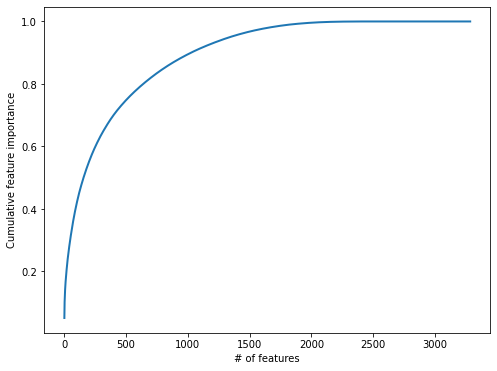

In [16]:
feature_importance["importance_cumsum"] = feature_importance["importance"].cumsum()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.plot(np.arange(feature_importance.shape[0]) + 1, feature_importance["importance_cumsum"].values, lw="2.")
ax.set_xlabel("# of features")
ax.set_ylabel("Cumulative feature importance")

In [20]:
feature_importance["importance_cumsum"].iloc[1500:2250]

1783    0.967816
2956    0.967911
158     0.968006
941     0.968101
331     0.968195
          ...   
1366    0.999491
3180    0.999497
1148    0.999502
2848    0.999508
2316    0.999514
Name: importance_cumsum, Length: 750, dtype: float64

In [21]:
selector = ImportantFeatureSelector(rf, threshold=2250)
selector.fit(X_train)
X_sel_train = selector.transform(X_train)
X_sel_test = selector.transform(X_test)

print("X_sel_train.shape", X_sel_train.shape)
print("X_sel_test.shape", X_sel_test.shape)

X_sel_train.shape (307511, 2250)
X_sel_test.shape (48744, 2250)


In [35]:
sel_features = [features[i] for i in selector._sel_cols]
X_sel_train = pd.DataFrame(X_sel_train, columns=sel_features)
X_sel_test = pd.DataFrame(X_sel_test, columns=sel_features)

print("X_sel_train.shape", X_sel_train.shape)
print("X_sel_test.shape", X_sel_test.shape)

X_sel_train.shape (307511, 2250)
X_sel_test.shape (48744, 2250)


In [38]:
X_sel_train["APPL_TARGET"] = y_train

X_sel_train.to_csv("data/data_/X_y_sel_rf_train.csv", index=False)
X_sel_test.to_csv("data/data_/X_sel_rf_test.csv", index=False)

del X_sel_train, X_sel_test

## Use feature importance from XGBoost

In [39]:
xgb = XGBClassifier(n_estimators=500, learning_rate=0.050, 
                    max_depth=8, min_child_weight=1, 
                    colsample_bytree=0.86, subsample=0.67,
                    reg_lambda=450,
                    n_jobs=20)
xgb.fit(X_train, y_train)

auc_xgb_train = roc_auc(xgb, X_train, y_train)
print("AUC of XGBoost model on the train set: %0.5f" % auc_xgb_train)

AUC of XGBoost model on the train set: 0.86647


In [40]:
feature_importance = feature_importance_df(xgb, features)
feature_importance.head(20)

,feature,importance
2825,APPL_CODE_GENDER_M,0.006439
2842,APPL_NAME_INCOME_TYPE_Working,0.006330
2964,APPL_AMT_GOODS_PRICE_4QCUT_Q2,0.005653
40,APPL_EXT_SOURCE_3,0.005410
39,APPL_EXT_SOURCE_2,0.005214
2827,APPL_FLAG_OWN_CAR_Y,0.005084
3127,PRAP_NAME_CONTRACT_STATUS_mode_Refused,0.004590
2846,APPL_NAME_EDUCATION_TYPE_Secondary / secondary...,0.004485
2843,APPL_NAME_EDUCATION_TYPE_Higher education,0.004383
180,BURE_AMT_CREDIT_SUM_DEBT_TO_SUM_max,0.003858


Text(0, 0.5, 'Cumulative feature importance')

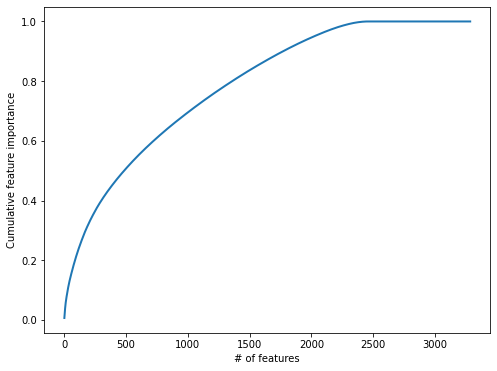

In [41]:
feature_importance["importance_cumsum"] = feature_importance["importance"].cumsum()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.plot(np.arange(feature_importance.shape[0]) + 1, feature_importance["importance_cumsum"].values, lw="2.")
ax.set_xlabel("# of features")
ax.set_ylabel("Cumulative feature importance")

In [52]:
feature_importance.iloc[:2455]

,feature,importance,importance_cumsum
2825,APPL_CODE_GENDER_M,0.006439,0.006439
2842,APPL_NAME_INCOME_TYPE_Working,0.006330,0.012769
2964,APPL_AMT_GOODS_PRICE_4QCUT_Q2,0.005653,0.018422
40,APPL_EXT_SOURCE_3,0.005410,0.023831
39,APPL_EXT_SOURCE_2,0.005214,0.029046
...,...,...,...
3261,PRAP_DAYS_TERMINATION_4QCUT_mode_Q4,0.000004,0.999990
2274,INPA_AMT_INSTAL_PAY_DIFF_ISPOSITIVE_sum_mm_diff,0.000004,0.999993
1519,INPA_AMT_INSTAL_PAY_DIFF_ISPOSITIVE_entropy_me...,0.000003,0.999997
1158,POBA_NAME_CONTRACT_STATUS_Completed_sum_min,0.000002,0.999999


In [54]:
selector = ImportantFeatureSelector(xgb, threshold=2455)
selector.fit(X_train)
X_sel_train = selector.transform(X_train)
X_sel_test = selector.transform(X_test)

print("X_sel_train.shape", X_sel_train.shape)
print("X_sel_test.shape", X_sel_test.shape)

X_sel_train.shape (307511, 2455)
X_sel_test.shape (48744, 2455)


In [55]:
sel_features = [features[i] for i in selector._sel_cols]
X_sel_train = pd.DataFrame(X_sel_train, columns=sel_features)
X_sel_test = pd.DataFrame(X_sel_test, columns=sel_features)

print("X_sel_train.shape", X_sel_train.shape)
print("X_sel_test.shape", X_sel_test.shape)

X_sel_train.shape (307511, 2455)
X_sel_test.shape (48744, 2455)


In [56]:
X_sel_train["APPL_TARGET"] = y_train

X_sel_train.to_csv("data/data_/X_y_sel_xgb_train.csv", index=False)
X_sel_test.to_csv("data/data_/X_sel_xgb_test.csv", index=False)

del X_sel_train, X_sel_test